In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import os
pd.set_option('display.max_columns', 30)

In [2]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [3]:
# Import samplesheets
cols = ["model_id", "BROAD_ID", "tissue", "cancer_type"]
col_rename = dict(
    ModelID="BROAD_ID",
    SangerModelID="model_id",
    SampleCollectionSite="tissue",
    OncotreeLineage="cancer_type",
)
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv")

ss_depmap = pd.read_csv(f"{data_folder}/depmap24Q4/Model.csv")
ss_depmap.rename(columns=col_rename, inplace=True)

# Map sample IDs to Sanger IDs
samplesheet = pd.concat(
    [
        ss_cmp[cols].dropna().assign(source="sanger"),
        ss_depmap[cols].dropna().assign(source="broad"),
    ]
)
samplesheet = samplesheet.groupby("model_id").first().reset_index()
samplesheet.replace(
    {
        "tissue": dict(
            large_intestine="Large Intestine",
            lung="Lung",
            ovary="Ovary",
            haematopoietic_and_lymphoid_tissue="Haematopoietic and Lymphoid",
            bone_marrow="Other tissue",
            upper_aerodigestive_tract="Other tissue",
            ascites="Other tissue",
            pleural_effusion="Other tissue",
        )
    },
    inplace=True,
)
tissue_map = samplesheet.set_index("model_id").to_dict()["tissue"]

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])

In [4]:
samplesheet.head()

model_id    BROAD_ID                       tissue          cancer_type  \
0  SIDM00001  ACH-000405  Haematopoietic and Lymphoid  Other Blood Cancers   
1  SIDM00002  ACH-002340    Peripheral Nervous System        Neuroblastoma   
2  SIDM00003  ACH-002159                         Skin             Melanoma   
3  SIDM00005  ACH-000044                       Breast     Breast Carcinoma   
4  SIDM00006  ACH-001552                         Skin  Other Solid Cancers   

   source  
0  sanger  
1  sanger  
2  sanger  
3  sanger  
4  sanger

In [5]:
samplesheet['tissue'].unique()

array(['Haematopoietic and Lymphoid', 'Peripheral Nervous System', 'Skin',
       'Breast', 'Ovary', 'Large Intestine', 'Esophagus', 'Lung',
       'Head and Neck', 'Central Nervous System', 'Kidney', 'Soft Tissue',
       'Bladder', 'Bone', 'Thyroid', 'Endometrium', 'Stomach', 'Pancreas',
       'Liver', 'Cervix', 'Eye', 'Prostate', 'Biliary Tract', 'Uterus',
       'Testis', 'Other tissue', 'Placenta', 'Small Intestine',
       'Adrenal Gland', 'Vulva', 'Unknown'], dtype=object)

In [6]:
PALETTE_TTYPE = {
    "Lung": "#007fff",
    "Prostate": "#665d1e",
    "Stomach": "#ffbf00",
    "Central Nervous System": "#fbceb1",
    "Skin": "#ff033e",
    "Bladder": "#ab274f",
    "Haematopoietic and Lymphoid": "#d5e6f7",
    "Kidney": "#7cb9e8",
    "Thyroid": "#efdecd",
    "Soft Tissue": "#8db600",
    "Head and Neck": "#e9d66b",
    "Ovary": "#b284be",
    "Bone": "#b2beb5",
    "Endometrium": "#10b36f",
    "Breast": "#6e7f80",
    "Pancreas": "#ff7e00",
    "Peripheral Nervous System": "#87a96b",
    "Cervix": "#c9ffe5",
    "Large Intestine": "#9f2b68",
    "Liver": "#00ffff",
    "Vulva": "#008000",
    "Esophagus": "#cd9575",
    "Biliary Tract": "#72a0c1",
    "Other tissue": "#a32638",
    "Small Intestine": "#9966cc",
    "Placenta": "#f19cbb",
    "Testis": "#e32636",
    "Adrenal Gland": "#3b7a57",
    "Uterus": "#7a3b5e",
    "Unknown": "#a32638",
    "Eye": "#ff1493",
}

In [7]:
# timestamp = "20250225_145621"
timestamp = "20250508_160635"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [8]:
growth.shape

(964, 6)

In [9]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
gexp_measured = gexp_measured[gexp_measured.index.isin(gexp_df.index)]

In [10]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
cas9_measured = cas9_measured[cas9_measured.index.isin(cas9_df.index)]

In [11]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))
measured_no_cas9 = list(set(cas9_df.index) - set(cas9_measured.index))

In [12]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [15]:
def plot_cas9_vs_gexp_comparison(
    cas9_id: str,
    gexp_id: str,
    cas9_df: pd.DataFrame,
    gexp_df: pd.DataFrame,
    measured_groups: dict,
    tissue_map: dict,
):
    """
    Create a 2x2 multi-panel scatter plot comparing gene expression and Cas9 scores using Seaborn.

    Parameters:
    -----------
    cas9_id : str
        Column name for Cas9 scores
    gexp_id : str
        Column name for gene expression scores
    cas9_df : pd.DataFrame
        DataFrame containing Cas9 scores
    gexp_df : pd.DataFrame
        DataFrame containing gene expression scores
    measured_groups : dict
        Dictionary with keys 'both', 'gexp_only', 'cas9_only', 'none'
        containing indices for each group
    tissue_map : dict
        Dictionary mapping model_ids to tissue types
    PALETTE_TTYPE : dict
        Dictionary mapping tissue types to colors.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    """
    import numpy as np
    import pandas as pd
    from scipy import stats
    import matplotlib.pyplot as plt
    import matplotlib.lines as mlines
    import seaborn as sns
    from sklearn.metrics import mean_squared_error

    # Prepare combined data
    combined_df = pd.merge(
        cas9_df[[cas9_id]], gexp_df[[gexp_id]], left_index=True, right_index=True
    )
    combined_df["tissue"] = combined_df.index.map(tissue_map)

    # Define unique tissues present in the data
    unique_tissues = sorted(combined_df["tissue"].dropna().unique())

    # Set up the figure in 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.ravel()  # Flatten axes array for easier iteration

    # Define the groups to plot with their corresponding dictionary keys
    plot_groups = [
        ("Both", "both"),
        ("Transcriptomics", "gexp_only"),
        ("CRISPR-Cas9", "cas9_only"),
        ("None", "none"),
    ]

    # Plot each group
    for ax, (title, group_key) in zip(axes, plot_groups):
        # Get indices for current group
        indices = measured_groups.get(group_key, [])  # Use .get for safety

        # Handle 'none' group explicitly by finding complement indices
        if group_key == "none":
            all_other_indices = set()
            for k, v in measured_groups.items():
                if k != "none":
                    all_other_indices.update(v)
            # Ensure indices are within the combined_df
            valid_indices = list(set(combined_df.index) - all_other_indices)
            indices = [idx for idx in valid_indices if idx in combined_df.index]

        if not indices:  # Skip if no indices for the group
            ax.set_title(f"{title} (N=0)")
            ax.set_xlabel(f"{gexp_id} (GExp)")
            ax.set_ylabel(f"{cas9_id} (Cas9)")
            continue

        # Filter data for the current group
        df_group = combined_df.loc[indices]

        # Extract data for calculations
        y = df_group[cas9_id]
        x = df_group[gexp_id]

        # Calculate correlation and RMSE
        # Drop NaN values for calculation to avoid errors
        valid_data = df_group[[gexp_id, cas9_id]].dropna()
        if len(valid_data) > 1:
            r = stats.pearsonr(valid_data[gexp_id], valid_data[cas9_id])[0]
            rmse = np.sqrt(mean_squared_error(valid_data[gexp_id], valid_data[cas9_id]))
        else:
            r, rmse = np.nan, np.nan  # Assign NaN if not enough data

        # Create scatter plot using Seaborn
        sns.scatterplot(
            data=df_group,
            x=gexp_id,
            y=cas9_id,
            hue="tissue",
            palette=PALETTE_TTYPE,
            ax=ax,
            s=20,
            legend=False,  # Turn off individual legends
            hue_order=unique_tissues,
        )  # Ensure consistent color mapping

        # Add trend line (only if enough data points)
        if len(valid_data) > 1:
            # Fit trend line only on non-NaN data
            z = np.polyfit(valid_data[gexp_id], valid_data[cas9_id], 2)
            p = np.poly1d(z)
            x_line = np.linspace(
                valid_data[gexp_id].min(), valid_data[gexp_id].max(), 100
            )
            ax.plot(x_line, p(x_line), color="black", linestyle="--")

        # Customize plot
        ax.set_xlabel(f"{gexp_id} (GExp)")
        ax.set_ylabel(f"{cas9_id} (Cas9)")

        # Add correlation and RMSE text
        ax.text(
            0.05,
            0.95,
            f"r={r:.2f}, rmse={rmse:.2f}",
            transform=ax.transAxes,
            fontsize=8,
            verticalalignment="top",
        )

        # Add title with N count
        ax.set_title(f"{title} (N={len(indices)})")

    # Create handles for the global legend using PALETTE_TTYPE
    handles = [
        mlines.Line2D(
            [],
            [],
            color=PALETTE_TTYPE[tissue],
            marker="o",
            linestyle="None",
            markersize=5,
            label=tissue,
        )
        for tissue in unique_tissues
        if tissue in PALETTE_TTYPE
    ]  # Ensure tissue exists in palette

    # Add the global legend to the right of the subplots
    fig.legend(
        handles=handles,
        title="Tissue",
        bbox_to_anchor=(0.9, 0.5),
        loc="center left",
        title_fontsize="medium",
        fontsize="small",
    )

    # Adjust layout to prevent overlap and make space for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right boundary for legend

    return fig

In [16]:
skew_df = pd.concat(
    [
        cas9_measured.apply(skew).astype(float).rename("skew_orig"),
        cas9_df.apply(skew).astype(float).rename("skew_mosa"),
    ],
    axis=1,
)

def build_string_ppi(score_thres=900):
    # ENSP map to gene symbol
    gmap = pd.read_csv(f"../data/ppi/9606.protein.aliases.v12.0.txt.gz", sep="\t")
    gmap = gmap[["BioMart_HUGO" in i.split(" ") for i in gmap["source"]]]
    gmap = gmap.groupby("#string_protein_id")["alias"].agg(lambda x: set(x)).to_dict()
    gmap = {k: list(gmap[k])[0] for k in gmap if len(gmap[k]) == 1}

    # Load String network
    net = pd.read_csv(f"../data/ppi/9606.protein.links.full.v12.0.txt.gz", sep=" ")

    # Filter by moderate confidence
    net = net[net["combined_score"] > score_thres]

    # Filter and map to gene symbol
    net = net[
        [p1 in gmap and p2 in gmap for p1, p2 in net[["protein1", "protein2"]].values]
    ]
    net["protein1"] = [gmap[p1] for p1 in net["protein1"]]
    net["protein2"] = [gmap[p2] for p2 in net["protein2"]]

    #  String network
    net_i = igraph.Graph(directed=False)

    # Initialise network lists
    edges = [(px, py) for px, py in net[["protein1", "protein2"]].values]
    vertices = list(set(net["protein1"]).union(net["protein2"]))

    # Add nodes
    net_i.add_vertices(vertices)

    # Add edges
    net_i.add_edges(edges)

    # Add edge attribute score
    net_i.es["score"] = list(net["combined_score"])

    # Simplify
    net_i = net_i.simplify(combine_edges="max")

    return net_i
ppi = build_string_ppi()
def ppi_dist_to_string(d, target_thres):
    if d == 0:
        res = "T"

    elif d == np.inf:
        res = "No link; No connection"

    elif d < target_thres:
        res = f"{int(d)}"

    else:
        res = f"{int(target_thres)}+"

    return res


def dist_crispr_gexp(crisprs, gexps, ppi):
    ppi_genes = set(ppi.vs["name"])
    genes = gexps.intersection(ppi_genes)
    assert len(genes) != 0, "No gexps overlapping with PPI provided"

    dmatrix = {
        c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))
        for c in crisprs
        if c in ppi_genes
    }

    return dmatrix


def ppi_annotation(df, ppi, target_thres=5):
    df_genes = set(df["x_id"])
    df_crispr = set(df["y_id"])

    # Calculate distance between gexp and crispr in PPI
    dist_d_g = dist_crispr_gexp(df_crispr, df_genes, ppi)

    # Annotate drug regressions
    def drug_gene_annot(c, g):
        if c == g:
            res = "T"

        elif c not in dist_d_g:
            res = "No link; CRISPR not in network"

        elif g not in dist_d_g[c]:
            res = "No link; Gene not in network"

        else:
            res = ppi_dist_to_string(dist_d_g[c][g], target_thres)

        return res

    df = df.assign(
        target_detailed=[
            drug_gene_annot(c, g) for c, g in df[["y_id", "x_id"]].values
        ]
    )

    df = df.assign(
        target=["-" if t.startswith("No link;") else t for t in df["target_detailed"]]
    )

    return df

In [17]:
def plot_scatter(
    cas9_name, gexp_name, measured_groups=None, tissue=None, model_list_df=None
):
    """
    Plot scatter with either all points or 4 measurement categories

    Parameters:
    -----------
    cas9: pd.Series
        CRISPR-Cas9 effects
    gexp: pd.Series
        Gene expression values
    measured_groups: dict, optional
        Dictionary with keys: 'both', 'gexp_only', 'cas9_only', 'none'
        containing lists of sample IDs for each category
    """
    cas9 = cas9_df[cas9_name]
    gexp = gexp_df[gexp_name]
    if tissue is not None and model_list_df is not None:
        # Filter data
        model_list = model_list_df[model_list_df["tissue"] == tissue].index.values
        cas9 = cas9[cas9.index.isin(model_list)]
        gexp = gexp[gexp.index.isin(model_list)]

    # Merge data and get common samples
    df = pd.DataFrame({"CRISPR": cas9, "Expression": gexp})
    df = df.dropna()

    # Calculate correlation
    corr, pval = stats.pearsonr(df["CRISPR"], df["Expression"])

    # Create plot
    plt.figure(figsize=(6, 6))

    if measured_groups is None:
        # Simple case: plot all points in green
        plt.scatter(
            df["Expression"],
            df["CRISPR"],
            c="green",
            alpha=0.6,
            label=f"All samples (n={len(df)})",
        )
    else:
        # Complex case with categories
        def get_category(idx):
            for cat in ["both", "gexp_only", "cas9_only"]:
                if idx in measured_groups[cat]:
                    return cat
            return "none"

        df["Category"] = df.index.map(get_category)

        n_both = df["Category"].value_counts().get("both", 0)
        n_gexp = df["Category"].value_counts().get("gexp_only", 0)
        n_cas9 = df["Category"].value_counts().get("cas9_only", 0)
        n_none = df["Category"].value_counts().get("none", 0)

        # Create color and label mapping
        category_config = {
            "both": {"color": "green", "label": f"Both Measured (N={n_both})"},
            "gexp_only": {"color": "blue", "label": f"Expression Only (N={n_gexp})"},
            "cas9_only": {"color": "gray", "label": f"CRISPR Only (N={n_cas9})"},
            "none": {"color": "red", "label": f"Both Imputed (N={n_none})"},
        }

        # Plot scatter points for each category
        for category, config in category_config.items():
            mask = df["Category"] == category
            if mask.any():
                plt.scatter(
                    df.loc[mask, "Expression"],
                    df.loc[mask, "CRISPR"],
                    c=config["color"],
                    alpha=0.6,
                    label=config["label"],
                )

    # Add regression line
    sns.regplot(
        data=df,
        y="CRISPR",
        x="Expression",
        scatter=False,
        color="black",
        line_kws={"linestyle": "--"},
    )

    # Annotate correlation
    plt.annotate(
        f"r = {corr:.3f}\np = {pval:.2e}\nn = {len(df)}",
        xy=(0.05, 0.85),
        xycoords="axes fraction",
        bbox=dict(facecolor="white", alpha=0.8),
    )

    # Labels and title
    plt.ylabel(f"{cas9_name} (Cas9)")
    plt.xlabel(f"{gexp_name} (GEXP)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    title = f"{cas9_name} (Cas9) vs {gexp_name} (GEXP)"
    if tissue is not None:
        title += f" ({tissue})"
    plt.title(title)

    return plt.gca()

In [18]:
COLS = [
    "y_id",
    "x_id",
    "beta_orig",
    "beta_vae",
    "fdr_orig",
    "fdr_vae",
    "diff_log10fdr",
    "skew_orig",
    "skew_mosa",
    "target",
]

In [19]:
def plot_volcano(
    df,
    beta_col,
    log10fdr_col,
    figsize=(6, 4),
    beta_threshold=0.04,
    fdr_threshold=50,
    title="Volcano Plot",
):
    """
    Create a volcano plot with annotations for significant points.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    beta_col : str
        Column name for beta values (x-axis)
    log10fdr_col : str
        Column name for -log10(FDR) values (y-axis)
    figsize : tuple, optional
        Figure size (width, height) in inches
    beta_threshold : float, optional
        Threshold for beta values to annotate points
    fdr_threshold : float, optional
        Threshold for -log10(FDR) values to annotate points
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from adjustText import adjust_text

    # Create the volcano plot
    plt.figure(figsize=figsize)

    # Create scatter plot
    plt.scatter(
        df[beta_col],
        df[log10fdr_col],
        alpha=0.5,
        s=10,
    )

    # Add labels and title
    plt.xlabel(beta_col)
    plt.ylabel("-log10(FDR)")
    plt.title(title)

    # Add a horizontal line for FDR threshold (e.g., 0.05)
    plt.axhline(y=-np.log10(0.05), color="r", linestyle="--", alpha=0.3)

    # Add annotations for significant points
    mask = (df[beta_col] > beta_threshold) | (df[log10fdr_col] > fdr_threshold)
    texts = []
    for idx, row in df[mask].iterrows():
        texts.append(
            plt.text(
                row[beta_col],
                row[log10fdr_col],
                f"{row['y_id']};{row['x_id']}",
                fontsize=8,
            )
        )

    # Adjust text positions to prevent overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

    # Adjust layout
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [20]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


def calculate_beta_raw(row):
    X = gexp_df[[row["x_id"]]]
    y = cas9_df[row["y_id"]]
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

def calculate_pearson_r(row):
    X = gexp_df[[row["x_id"]]].values.flatten()  # flatten to 1D array
    y = cas9_df[row["y_id"]].values
    r, _ = pearsonr(X, y)  # pearsonr returns (r, p-value)
    return r

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import entropy


def calculate_tissue_dependency_entropy(cas9_df, tissue_types_series, threshold=-0.2):
    """
    Calculates the normalized Shannon entropy of tissue types for dependent cell lines for each gene.

    Args:
        cas9_df (pd.DataFrame): DataFrame with samples as index and genes as columns,
                                containing essentiality scores.
        tissue_types_series (pd.Series): Series with samples as index and tissue types
                                         as values. Index must match cas9_df.
        threshold (float): Essentiality score threshold to define dependency.

    Returns:
        pd.DataFrame: DataFrame with genes as index and a single column
                      'normalized_entropy' containing the calculated normalized entropy
                      for each gene. Returns NaN for genes with no dependent cell lines.
                      Returns 0 for genes dependent only in one tissue type.
                      Normalization is done based on the total number of unique tissues
                      present in the dataset.
    """

    # Ensure index alignment (important for merging/lookup)
    if not cas9_df.index.equals(tissue_types_series.index):
        # Attempt to align if indices contain the same elements but in different order
        common_index = cas9_df.index.intersection(tissue_types_series.index)
        print("Warning: Realigning indices between cas9_df and tissue_types_series.")
        cas9_df = cas9_df.loc[common_index]
        tissue_types_series = tissue_types_series.loc[common_index]

    all_unique_tissues = tissue_types_series.unique()
    n_total_tissues = len(all_unique_tissues)

    if n_total_tissues <= 1:
        print(
            "Warning: Only one or zero unique tissue types found in the dataset. Normalized entropy will be 0."
        )
        max_entropy = 1.0  # Avoid division by zero, result will be 0 anyway.
    else:
        max_entropy = np.log2(n_total_tissues)

    gene_entropy_results = {}

    for gene in cas9_df.columns:
        gene_scores = cas9_df[gene]
        dependent_samples_mask = gene_scores < threshold
        dependent_indices = gene_scores[dependent_samples_mask].index

        if len(dependent_indices) == 0:
            # No dependent cell lines for this gene
            gene_entropy_results[gene] = np.nan
            continue

        # Get tissue types for dependent cell lines
        dependent_tissues = tissue_types_series.loc[dependent_indices]

        # Calculate frequencies and probabilities
        tissue_counts = dependent_tissues.value_counts()

        if len(tissue_counts) <= 1:
            # Dependent samples are all from one tissue type (or none, handled above)
            gene_entropy_results[gene] = np.nan
            continue

        # Calculate Shannon entropy (base 2)
        # scipy.stats.entropy calculates p*log(p), sums, and negates
        gene_shannon_entropy = entropy(tissue_counts, base=2)

        # Normalize entropy
        normalized_gene_entropy = gene_shannon_entropy / max_entropy
        gene_entropy_results[gene] = normalized_gene_entropy

    # Convert results to DataFrame
    entropy_df = pd.DataFrame.from_dict(
        gene_entropy_results, orient="index", columns=["normalized_entropy"]
    )
    entropy_df.index.name = "gene"

    return entropy_df


entropy_results = calculate_tissue_dependency_entropy(
    cas9_df, samplesheet.set_index("model_id")["tissue"]
)

# pan-cancer level

In [24]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue.csv.gz"
)
# df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
# df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
# df_res_vae['diff_log10p'] = df_res_vae['log10p_vae'] - df_res_vae['log10p_orig']
# df_res_vae = df_res_vae.sort_values("diff_log10p", ascending=False)

In [ ]:
df_res_vae.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue.csv.gz",
    index=False,
)
df_res_vae.head()

In [ ]:
df_res_vae.head()

In [ ]:
df_res_vae_annot = pd.merge(df_res_vae, skew_df, left_on="y_id", right_index=True)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)

In [27]:
# Convert entropy_results to a dictionary to handle potential duplicate indices
entropy_dict = entropy_results['normalized_entropy'].to_dict()
# Map the dictionary to y_id values
df_res_vae_annot['entropy'] = df_res_vae_annot['y_id'].map(entropy_dict)

In [ ]:
df_res_vae_annot.round(5).head()

In [29]:
numeric_cols = df_res_vae_annot.select_dtypes(
    include=["float64", "float32"]
).columns  # Remove specific columns from numeric_cols
columns_to_remove = ["pval_orig", "fdr_orig", "pval_vae", "fdr_vae"]
numeric_cols = [col for col in numeric_cols if col not in columns_to_remove]

In [30]:
df_res_vae_annot[numeric_cols] = df_res_vae_annot[numeric_cols].round(5)

In [ ]:
df_res_vae_annot.head()

In [32]:
df_res_vae_annot.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz",
    index=False,
)

In [122]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz",index_col=0
)

In [14]:
df_res_vae_annot['log10fdr_orig'] = -np.log10(df_res_vae_annot['fdr_orig'])
df_res_vae_annot['log10fdr_vae'] = -np.log10(df_res_vae_annot['fdr_vae'])
df_res_vae_annot['diff_log10fdr'] = df_res_vae_annot['log10fdr_vae'] - df_res_vae_annot['log10fdr_orig']

In [ ]:
df_res_vae_annot.shape

In [ ]:
df_res_vae_filtered = df_res_vae_annot.query("log10fdr_vae > 2")
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["beta_vae"].abs() > 0.015]

# df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["target"].isin(['T', '1', '2', '3','4','5'])]
df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -1.5")

In [ ]:
df_res_vae_filtered.shape

In [ ]:
df_res_vae_filtered

In [33]:
df_res_vae_filtered[COLS].to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot_filtered.csv", index=None
)

In [ ]:
for row in df_res_vae_filtered[COLS].head(10).itertuples():
    plot_scatter(row.y_id, row.x_id, measured_groups=measured_groups, tissue=None, model_list_df=ss_cmp)

In [ ]:
plot_scatter("MYB", "BCAR1", measured_groups=measured_groups, model_list_df=ss_cmp)

# tissue level

In [10]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue.csv.gz"
)


In [11]:
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae["diff_log10p"] = df_res_vae["log10p_vae"] - df_res_vae["log10p_orig"]
df_res_vae["log10fdr_orig"] = -np.log10(df_res_vae["fdr_orig"])
df_res_vae["log10fdr_vae"] = -np.log10(df_res_vae["fdr_vae"])
df_res_vae["diff_log10fdr"] = df_res_vae["log10fdr_vae"] - df_res_vae["log10fdr_orig"]
df_res_vae = df_res_vae.sort_values("diff_log10fdr", ascending=False)

In [12]:
df_res_vae.loc[:,"n_samples_diff"] = (
    df_res_vae["n_samples_vae"] - df_res_vae["n_samples_orig"]
)
df_res_vae.loc[:,"n_samples_diff_pct"] = (
    df_res_vae["n_samples_diff"] / df_res_vae["n_samples_orig"]
)

In [ ]:
df_res_vae_filtered = df_res_vae.query("log10fdr_vae > 2 and log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[df_res_vae["beta_vae"].abs() > 0.03]
df_res_vae_annot = pd.merge(
    df_res_vae_filtered, skew_df, left_on="y_id", right_index=True
)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)
# df_res_vae_annot = df_res_vae_annot[
#     df_res_vae_annot["target"].isin(["T", "1", "2", "3", "4", "5"])
# ]
df_res_vae_annot = df_res_vae_annot.query("skew_orig < -2 and skew_mosa < -1.5")

In [33]:
COLS = ["y_id", "x_id", "beta_orig", "beta_vae", "fdr_orig", "fdr_vae", "diff_log10fdr", "skew_orig", "skew_mosa", "target"]
# df_res_vae_annot[COLS+['tissue']]

In [ ]:
df_res_vae_filtered.query("y_id == 'KRAS' and x_id == 'AREG'")

In [20]:
df_res_vae.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv",
    index=False,
)

In [21]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv"
)

In [22]:
df_res_vae_annot[COLS + ["tissue"]].to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered_annot.csv", index=None
)

In [23]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered_annot.csv"
)

In [ ]:
df_res_vae[
    ["tissue", "n_samples_orig", "n_samples_diff", "n_samples_diff_pct"]
].drop_duplicates().sort_values("n_samples_diff_pct")

In [ ]:
df_res_vae[
    ["tissue", "n_samples_orig", "n_samples_diff", "n_samples_diff_pct"]
].drop_duplicates().sort_values("n_samples_diff_pct")

In [ ]:
df_res_vae_annot['target'].value_counts()

In [ ]:
for row in df_res_vae_annot.head(10).itertuples():
    plot_scatter(row.y_id, row.x_id, measured_groups=measured_groups, tissue=row.tissue, model_list_df=ss_cmp)

# Filtering for Dave

In [ ]:
gene_list_df = pd.read_excel("../data/FINAL list of FUR driver genes_15th_Feb_25 copy.xlsx")
gene_list_df.head()
gene_names_list = gene_list_df["Gene name"].drop_duplicates().dropna().to_list()
len(gene_names_list)

## pop corrected

In [22]:
# df_res_vae_annot = pd.read_csv(
#     f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz",index_col=0
# )

# df_res_vae_annot = pd.read_csv(
#     f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot_popcorrected.csv.gz",
#     index_col=0,
# )

df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [ ]:
df_res_vae_annot.head()

In [170]:
from statsmodels.stats.multitest import multipletests

# Group by y_id and apply BH correction separately for each group
result_dfs = []
for y_id, group in df_res_vae_annot.groupby("y_id"):
    # Apply BH correction for original p-values
    _, fdr_orig, _, _ = multipletests(group["pval_orig"], method="fdr_bh")
    group_copy = group.copy()
    group_copy["fdr_orig"] = fdr_orig

    # Apply BH correction for VAE p-values
    _, fdr_vae, _, _ = multipletests(group["pval_vae"], method="fdr_bh")
    group_copy["fdr_vae"] = fdr_vae

    result_dfs.append(group_copy)

# Combine all corrected groups back into a single DataFrame
df_res_vae_annot_corrected = pd.concat(result_dfs)

# Either assign back to original variable or use new variable
# df_res_vae_annot = df_res_vae_annot_corrected

In [24]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)

In [ ]:
sns.displot(df_res_vae_annot[df_res_vae_annot["y_id"] == "CTNNB1"]["pval_vae"])
plt.title("CTNNB1")

In [78]:
# df_res_vae_filtered = df_res_vae_annot.query("log10fdr_vae > 2")
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 2")

# df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["target"].isin(['T', '1', '2', '3','4','5'])]
# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -2")

In [ ]:
df_res_vae_filtered.head()

In [ ]:
plot_volcano(
    df=df_res_vae_filtered,
    beta_col="beta_vae",
    log10fdr_col="log10fdr_vae",
    beta_threshold=0.5,
    fdr_threshold=100,
    title="Volcano Plot (MOSA)",
)

In [ ]:
plot_volcano(
    df=df_res_vae_filtered,
    beta_col="beta_orig",
    log10fdr_col="log10fdr_orig",
    beta_threshold=0.7,
    fdr_threshold=100,
    title="Volcano Plot (Original)",
)

In [ ]:
plot_volcano(
    df=df_res_vae_filtered[df_res_vae_filtered["y_id"].isin(gene_names_list)],
    beta_col="beta_vae",
    log10fdr_col="log10fdr_vae",
    beta_threshold=0.2,
    fdr_threshold=6,
    title="Volcano Plot (MOSA) - Filtered List",
)

In [ ]:
df_res_vae_filtered.sort_values("log10fdr_vae", ascending=False).head(10)

In [ ]:
fig = plot_cas9_vs_gexp_comparison(
    cas9_id="FAM50A",
    gexp_id="FAM50B",
    cas9_df=cas9_df,
    gexp_df=gexp_df,
    measured_groups=measured_groups,
    tissue_map=tissue_map
)
plt.show()

In [ ]:
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 1")
df_res_vae_filtered.shape

In [ ]:
df_res_vae_filtered.groupby("y_id").size().sort_values(ascending=False)

In [84]:
df_res_vae_filtered.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_popcorrected_latent_filtered.csv",
    index=False,
)

In [34]:
df_final = df_res_vae_filtered[df_res_vae_filtered["y_id"].isin(gene_names_list)]
df_final = df_final.sort_values("log10fdr_vae", ascending=False)

In [ ]:
df_final[COLS]['y_id'].nunique()

In [ ]:
df_final.shape

In [ ]:
df_final[COLS].head()

In [38]:
df_final_formatted = df_final[COLS]
# Rename columns from "_vae" to "_mosa" using a more succinct approach
df_final_formatted = df_final_formatted.rename(columns={col: col.replace('_vae', '_mosa') for col in df_final_formatted.columns if '_vae' in col})
# Rename y_id to crispr_gene and x_id to rna_gene
df_final_formatted = df_final_formatted.rename(columns={'y_id': 'crispr_gene', 'x_id': 'rna_gene'})

In [ ]:
df_final_formatted.groupby("crispr_gene").size().sort_values(ascending=False)

In [40]:
df_final_formatted.to_csv(
    f"../reports/vae/crispr/crisprcas9_transcriptomics_SL_pairs_Dave_{timestamp}_all_latent_covariate.csv",
    index=False,
)

In [ ]:
df_final_formatted = pd.read_csv(
    f"../reports/vae/crispr/crisprcas9_transcriptomics_SL_pairs_Dave_{timestamp}_all_latent_covariate.csv",
)
df_final_formatted.groupby("crispr_gene").size().sort_values(ascending=False)

In [ ]:
df_final_formatted.shape

# validation score

In [22]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [23]:
df_res_vae_annot.head()

y_id    x_id  n_orig  beta_orig    lr_orig  covs_orig      pval_orig  \
0  FAM50A  FAM50B   923.0    0.75825  775.49438      208.0  1.148490e-170   
1   DDX3X   DDX3Y   923.0    0.70104  628.13085      208.0  1.274517e-138   
2   DDX3X   USP9Y   923.0    0.66805  569.93911      208.0  5.788442e-126   
3   DDX3X     UTY   923.0    0.67039  566.34511      208.0  3.502334e-125   
4  EIF1AX  EIF1AY   923.0    0.69643  563.47514      208.0  1.474560e-124   

        fdr_orig   n_vae  beta_vae     lr_vae  covs_vae       pval_vae  \
0  1.975632e-166  1523.0   0.62305  846.16667     211.0  4.953857e-186   
1  2.192424e-134  1523.0   0.54253  592.67442     211.0  6.564286e-131   
2  9.957278e-122  1523.0   0.50986  522.08826     211.0  1.486670e-115   
3  6.024714e-121  1523.0   0.50949  523.46762     211.0  7.449375e-116   
4  2.536539e-120  1523.0   0.54443  528.78237     211.0  5.198192e-117   

         fdr_vae  skew_orig  skew_mosa                 target_detailed target  \
0  1.802213e-182   -0.62729   -0.38142  No link; CRISPR not in network      -   
1  2.388087e-127    0.54274   -0.18181                               3      3   
2  5.408505e-112    0.54274   -0.18181                               3      3   
3  2.710083e-112    0.54274   -0.18181                               3      3   
4  1.891102e-113    0.61340   -0.24279                               1      1   

   entropy  
0  0.82245  
1  0.83160  
2  0.83160  
3  0.83160  
4  0.83172

In [24]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
# df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 3 and log10fdr_orig < 3")
df_res_vae_filtered = df_res_vae_filtered.query(
    "log10fdr_vae > 2"
)

# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -1.5 and skew_mosa < -1.5")
df_res_vae_filtered["corr_raw"] = df_res_vae_filtered.apply(calculate_pearson_r, axis=1)
df_res_vae_filtered = df_res_vae_filtered.query("corr_raw > 0.3")
df_res_vae_filtered = df_res_vae_filtered.reset_index(drop=True)

In [25]:
df_res_vae_filtered_delta = df_res_vae_filtered.query(
    "log10fdr_vae > 3 and log10fdr_orig < 3 and entropy > 0.7 and corr_raw > 0.5"
).sort_values("diff_log10fdr", ascending=False)
df_res_vae_filtered_delta

y_id      x_id  n_orig  beta_orig   lr_orig  covs_orig     pval_orig  \
1388    DTYMK      GJA1   923.0    0.13460  11.91582      208.0  5.565933e-04   
455      GMPS      GJA1   923.0    0.16769  21.08627      208.0  4.390621e-06   
1791     CDS2     BSPRY   923.0    0.15498   9.76961      208.0  1.774200e-03   
1343     ACO2      GJA1   923.0    0.13778  12.50538      208.0  4.057809e-04   
1416    SOX10   SLC38A1   923.0    0.08315  11.44776      208.0  7.158021e-04   
1832     TFRC      GJA1   923.0    0.09599   6.52759      208.0  1.062137e-02   
1821    PAICS      GJA1   923.0    0.09293   7.27058      208.0  7.009323e-03   
796      PFAS      GJC1   923.0    0.16238  17.29360      208.0  3.202634e-05   
1457     SDHB      GJA1   923.0    0.10863  11.33542      208.0  7.604271e-04   
1129    NAA10     PAGE5   923.0    0.16015  16.89654      208.0  3.947346e-05   
364     PSMB6     PSMB9   923.0    0.24294  26.90222      208.0  2.140126e-07   
1757     PFAS      GJA1   923.0    0.10369   8.27316      208.0  4.023539e-03   
524     NAA10   DCAF4L2   923.0    0.15949  22.27087      208.0  2.367714e-06   
1569   CHMP4B     PTPN6   923.0    0.16433  11.59811      208.0  6.601890e-04   
902    IMPDH2      GJA1   923.0    0.14948  15.15248      208.0  9.916810e-05   
1307     IPPK     MMP28   923.0    0.17944  17.37602      208.0  3.066707e-05   
1735    GFPT1     GFPT2   923.0    0.16378  14.01887      208.0  1.809855e-04   
1015    EFR3A  HSD17B14   923.0    0.13792  18.85851      208.0  1.407818e-05   
703     EFR3A      CHRD   923.0    0.14273  19.44387      208.0  1.036000e-05   
1743   FERMT2   TMEM238   923.0    0.15079  11.70208      208.0  6.243024e-04   
1534     ADSL      GJA1   923.0    0.11233  10.41691      208.0  1.248670e-03   
1176     UMPS      GJC1   923.0    0.15019  13.93247      208.0  1.894970e-04   
416     NAA10     PAGE2   923.0    0.17250  24.63717      208.0  6.920405e-07   
1790    DTYMK      SSPN   923.0    0.09748   7.28477      208.0  6.954145e-03   
1648   ZNF217    CLDN12   923.0    0.17885  11.38929      208.0  7.386867e-04   
1680   CHMP4B      CRB3   923.0    0.20235  10.46028      208.0  1.219690e-03   
1028      MVD      GJA1   923.0    0.14905  14.22641      208.0  1.620794e-04   
1327   CTNNB1     TCEA2   923.0    0.13925  17.37422      208.0  3.069620e-05   
1723   CHMP4B   TMEM102   923.0    0.10477   9.24101      208.0  2.366540e-03   
603      AHCY      GJA1   923.0    0.16561  17.99795      208.0  2.211430e-05   
858      EMC1   FAM71E1   923.0    0.14908  18.71567      208.0  1.517305e-05   
851      CDS2   ZDHHC23   923.0    0.14365  18.98449      208.0  1.317855e-05   
1298     MAU2      NPR3   923.0    0.16251  17.88166      208.0  2.350750e-05   
1526   CTNNB1       QKI   923.0    0.12730  15.65006      208.0  7.621008e-05   
1405   STXBP3   KATNAL1   923.0    0.17505  12.95739      208.0  3.186610e-04   
1295    ITGB1     TBL1X   923.0    0.12163  17.31236      208.0  3.171183e-05   
1070     STX4   KATNAL1   923.0    0.17221  14.93041      208.0  1.115501e-04   
582     FGFR1   SLC37A1   923.0    0.18213  19.12384      208.0  1.225048e-05   
940      CFL1    BMERB1   923.0    0.16950  21.80861      208.0  3.012453e-06   
915     TEAD3     CD320   923.0    0.17489  18.79987      208.0  1.451772e-05   
698      PPCS     SCRN1   923.0    0.16360  18.90625      208.0  1.373022e-05   
793     MYBL2      MYLK   923.0    0.17775  19.98126      208.0  7.820481e-06   
411    EEFSEC     AIFM2   923.0    0.18325  22.55955      208.0  2.037294e-06   
558      PSTK     AIFM2   923.0    0.18332  19.99685      208.0  7.756974e-06   
665     NAA10     SSX2B   923.0    0.16706  21.79072      208.0  3.040680e-06   
323      MANF       SHB   923.0    0.21179  24.98528      208.0  5.776957e-07   
579     MYBL2      CSF1   923.0    0.20306  23.82608      208.0  1.054442e-06   
443     THAP1     PSMB8   923.0    0.25482  25.57230      208.0  4.261128e-07   
290   SEPSECS     AIFM2   923.0    0.202

In [26]:
df_res_vae_filtered_delta.to_csv(
    f"../reports/vae/crispr/{timestamp}_popcorrected_latent_filtered_delta_fdr_entropy.csv",
    index=False,
)

In [27]:
df_res_vae_filtered.shape

(1898, 23)

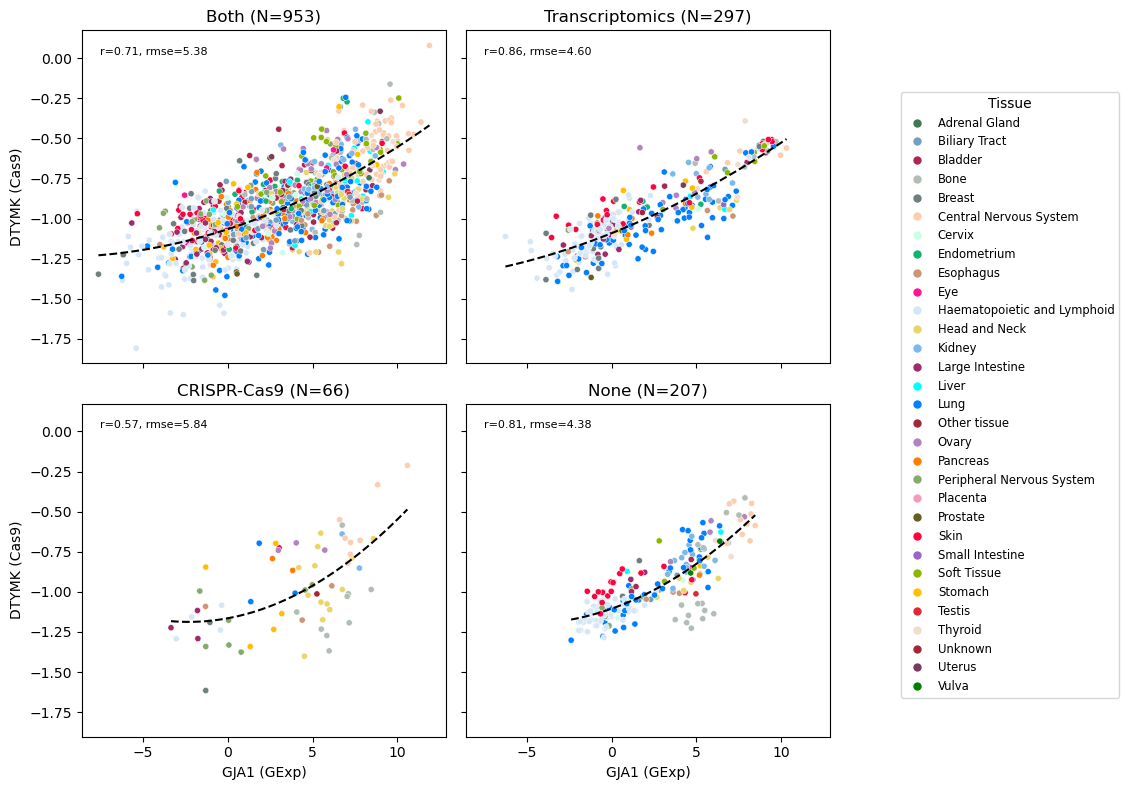

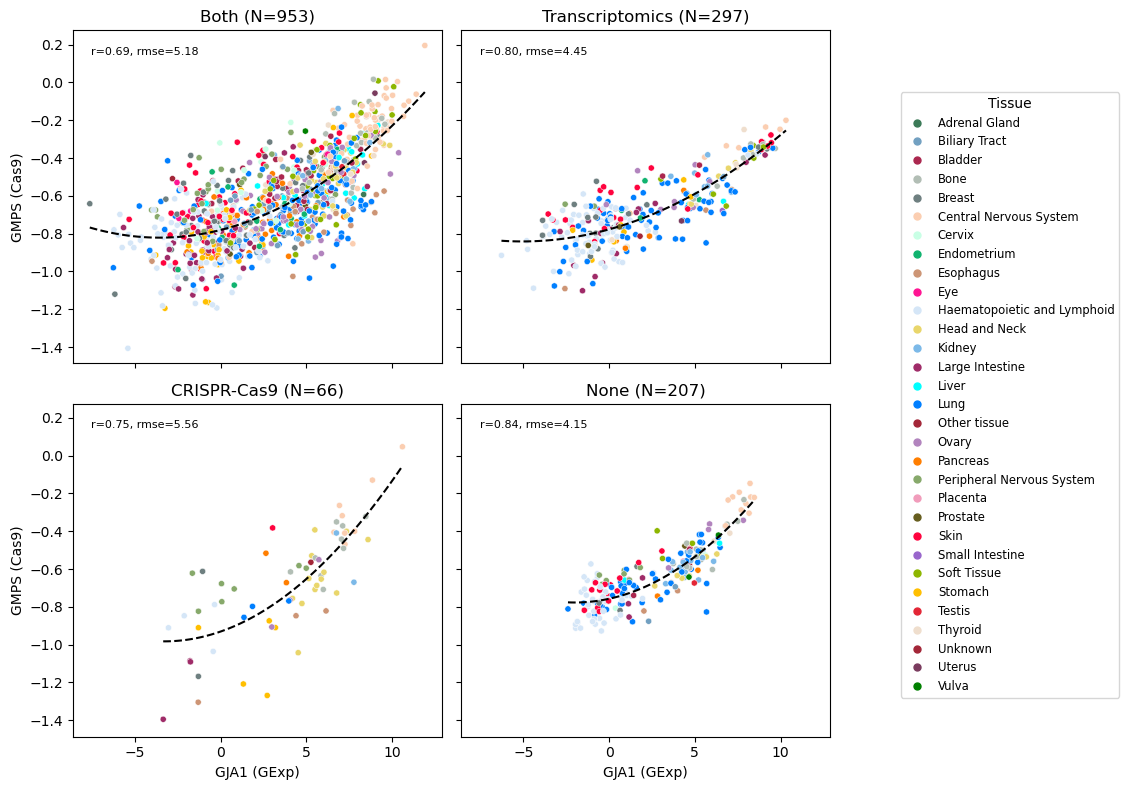

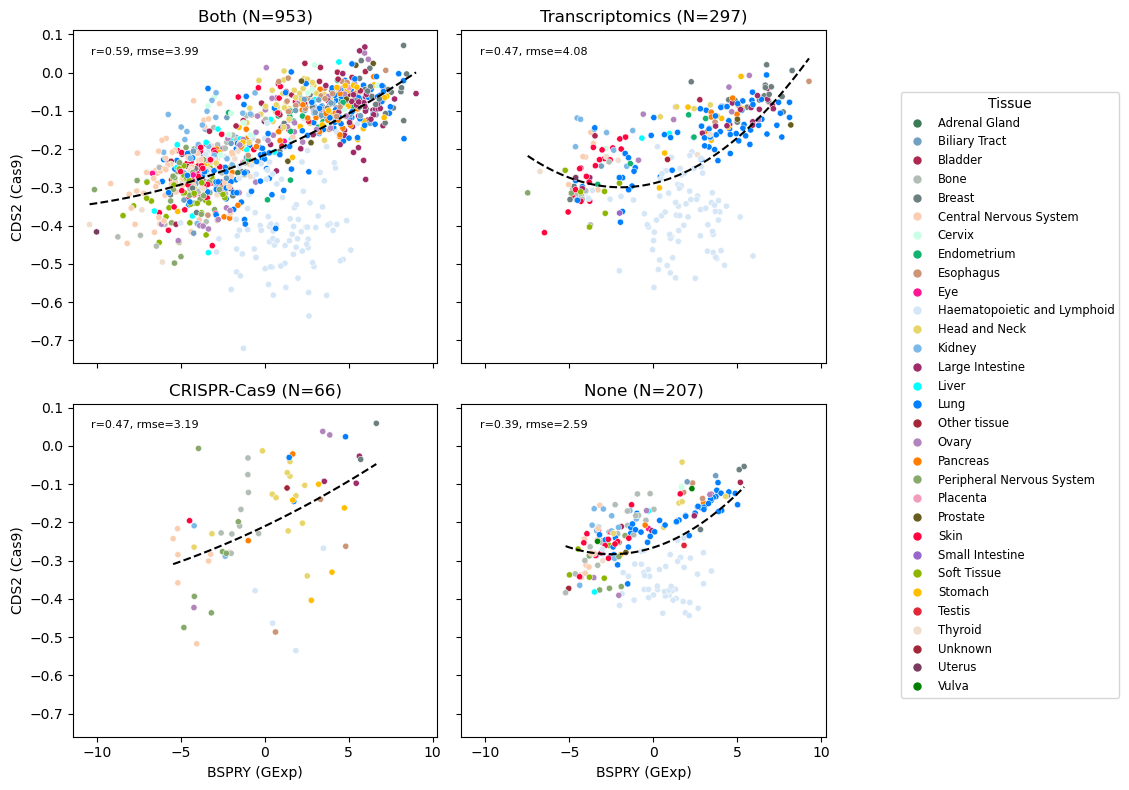

In [28]:
for row in df_res_vae_filtered_delta.head(3).itertuples():
    fig = plot_cas9_vs_gexp_comparison(
        cas9_id=row.y_id,
        gexp_id=row.x_id,
        cas9_df=cas9_df,
        gexp_df=gexp_df,
        measured_groups=measured_groups,
        tissue_map=tissue_map
    )
    plt.show()

<Axes: title={'center': 'EFR3A (Cas9) vs EFR3B (GEXP)'}, xlabel='EFR3B (GEXP)', ylabel='EFR3A (Cas9)'>

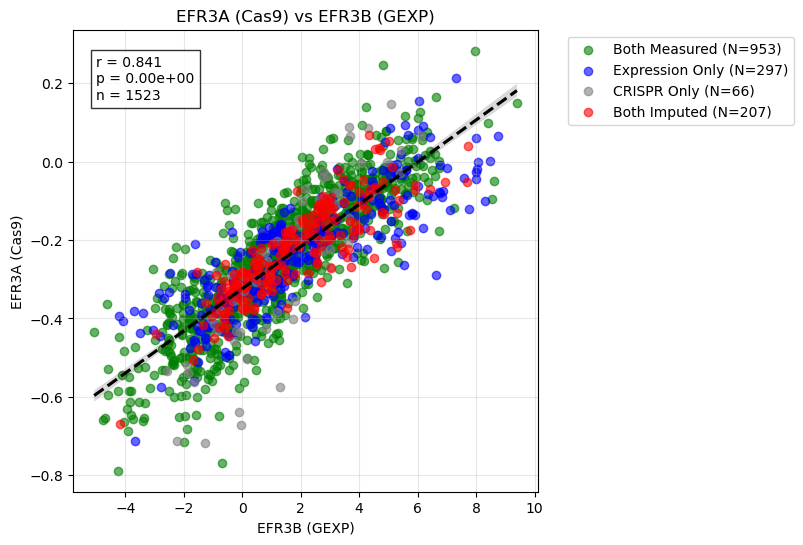

In [29]:
plot_scatter("EFR3A", "EFR3B", measured_groups=measured_groups, model_list_df=ss_cmp)

## cell line selection

In [30]:
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"] > 0]
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 3 and log10fdr_orig < 3")

# df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -1.5 and skew_mosa < -1.5")
df_res_vae_filtered["beta_raw"] = df_res_vae_filtered.apply(calculate_beta_raw, axis=1)
df_res_vae_filtered = df_res_vae_filtered.query("beta_raw > 0")
df_res_vae_filtered = df_res_vae_filtered.reset_index(drop=True)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import time


def select_validation_cell_lines(
    df_res_vae_filtered,
    gexp_df,
    cas9_df,
    num_cell_lines=6,
    threshold_percentile=75,
    n_jobs=20,
    crispr_threshold=0,
    expression_threshold=0,
    create_visualizations=False,
    visualize_top_n=10,
    output_dir="./validation_results",
):
    """
    Integrated pipeline to select optimal cell lines for synthetic lethality validation.
    Enforces both CRISPR and expression thresholds to identify strong synthetic lethality.

    Parameters:
    - df_res_vae_filtered: DataFrame containing gene pairs and significance measurements
    - gexp_df: DataFrame containing gene expression data
    - cas9_df: DataFrame containing CRISPR scores
    - num_cell_lines: Number of cell lines to select
    - threshold_percentile: Percentile threshold for considering a cell line adequate
    - n_jobs: Number of parallel jobs for score calculation
    - crispr_threshold: Maximum CRISPR score to consider a dependency (default=-0.6)
    - expression_threshold: Maximum expression value to consider low expression (default=0)
    - create_visualizations: Whether to create visualizations
    - visualize_top_n: Number of top gene pairs to visualize
    - output_dir: Directory to save visualizations

    Returns:
    - Dictionary with selected cell lines and evaluation metrics
    """
    print("Starting optimized cell line selection pipeline...")
    overall_start_time = time.time()

    # Step 1: Extract gene pairs and weights from the filtered results dataframe
    print("Extracting gene pairs and weights...")
    gene_pairs = list(zip(df_res_vae_filtered["y_id"], df_res_vae_filtered["x_id"]))

    # Create weights based on diff_log10fdr (delta significance)
    weights = pd.Series(
        df_res_vae_filtered["diff_log10fdr"].values,
        index=pd.MultiIndex.from_tuples(gene_pairs, names=["cas9_gene", "gexp_gene"]),
    )

    # Normalize weights to range [0, 1]
    if not weights.empty and weights.max() != weights.min():
        weights = (weights - weights.min()) / (weights.max() - weights.min())

    # Step 2: Calculate validation scores using parallel processing with thresholds
    print(f"Calculating validation scores with both thresholds...")
    validation_scores = calculate_validation_scores(
        gene_pairs,
        gexp_df,
        cas9_df,
        df_res_vae_filtered,
        n_jobs=n_jobs,
        crispr_threshold=crispr_threshold,
        expression_threshold=expression_threshold,
    )

    # Check if any valid scores remain after filtering
    if validation_scores.sum().sum() == 0:
        print(f"ERROR: No gene pairs have cell lines that pass both thresholds")
        print(f"CRISPR > {crispr_threshold} AND Expression > {expression_threshold}")
        print("Please try less stringent thresholds.")
        return None

    # Step 3: Create binary coverage matrix
    print("Creating coverage matrix using threshold...")
    coverage_matrix = create_coverage_matrix(validation_scores, threshold_percentile)

    # Step 4: Select optimal cell lines with optimized algorithm
    print("Selecting optimal cell lines using optimized algorithm...")
    selection_results = select_optimal_cell_lines(
        coverage_matrix, weights, num_cell_lines
    )

    # Step 5: Evaluate the selection
    print("Evaluating cell line selection...")
    evaluation_results = evaluate_cell_line_selection(
        coverage_matrix,
        selection_results["selected_cell_lines"],
        weights,
        df_res_vae_filtered,
    )

    # Combine results
    results = {
        "selected_cell_lines": selection_results["selected_cell_lines"],
        "cell_line_coverage": selection_results["pairs_covered_per_cell"],
        "validation_scores": validation_scores,
        "coverage_matrix": coverage_matrix,
        "evaluation": evaluation_results,
        "gene_pair_examples": selection_results["gene_pair_examples"],
        "thresholds": {"crispr": crispr_threshold, "expression": expression_threshold},
    }

    overall_elapsed_time = time.time() - overall_start_time
    print(f"\nTotal pipeline execution time: {overall_elapsed_time:.2f} seconds")

    # Print a summary
    print("\n----- RESULTS SUMMARY -----")
    print(
        f"\nRESULTS WITH THRESHOLDS: CRISPR > {crispr_threshold} AND Expression > {expression_threshold}"
    )
    print("\nSelected Cell Lines:")
    for i, cell_line in enumerate(results["selected_cell_lines"]):
        num_pairs = len(selection_results["covered_by_cell_line"][i])
        print(
            f"{i+1}. {cell_line} - Covers {num_pairs} gene pairs "
            + f"({num_pairs/len(gene_pairs)*100:.2f}% of total)"
        )

    print(f"\nOverall Coverage: {evaluation_results['overall_coverage_percent']:.2f}%")
    print(f"Top Pair Coverage: {evaluation_results['top_pair_coverage_percent']:.2f}%")
    print(f"Weighted Coverage: {evaluation_results['weighted_coverage_percent']:.2f}%")

    # Create visualizations if requested
    if create_visualizations:
        # Implement visualization code here (from previous response)
        pass

    return results


def calculate_validation_scores(
    gene_pairs,
    gexp_df,
    cas9_df,
    df_res_vae_filtered,
    n_jobs=20,
    crispr_threshold=0,
    expression_threshold=0,
):
    """
    Calculate synthetic lethality validation scores for all gene pairs across all cell lines.
    Apply both CRISPR and expression thresholds for filtering.

    Parameters:
    - gene_pairs: List of tuples where each tuple is (cas9_gene, gexp_gene)
    - gexp_df: DataFrame containing gene expression data, with genes as columns
    - cas9_df: DataFrame containing CRISPR scores, with genes as columns
    - df_res_vae_filtered: DataFrame containing gene pairs and their diff_log10fdr values
    - n_jobs: Number of parallel jobs to run (default=20)
    - crispr_threshold: Maximum CRISPR score to consider a dependency (default=-0.6)
    - expression_threshold: Maximum expression value to consider low expression (default=0)

    Returns:
    - validation_score_matrix: DataFrame with gene pairs as rows and cell lines as columns
    """
    # Ensure we're working with cell lines common to both datasets
    common_cell_lines = gexp_df.index.intersection(cas9_df.index)
    print(
        f"Found {len(common_cell_lines)} cell lines common to both expression and CRISPR datasets"
    )

    # Initialize validation score matrix
    validation_scores = pd.DataFrame(
        index=pd.MultiIndex.from_tuples(gene_pairs, names=["cas9_gene", "gexp_gene"]),
        columns=common_cell_lines,
    )

    # Create a lookup dictionary for diff_log10fdr values
    diff_fdr_dict = {}
    for _, row in df_res_vae_filtered.iterrows():
        diff_fdr_dict[(row["y_id"], row["x_id"])] = row["diff_log10fdr"]

    # Normalize diff_log10fdr values to a range of [1, 2]
    if diff_fdr_dict:
        min_diff = min(diff_fdr_dict.values())
        max_diff = max(diff_fdr_dict.values())
        diff_range = max_diff - min_diff

        if diff_range > 0:
            for pair in diff_fdr_dict:
                # Scale to [0,1] and then to [1,2]
                diff_fdr_dict[pair] = 1 + (
                    (diff_fdr_dict[pair] - min_diff) / diff_range
                )

    # Function to process a single gene pair
    def process_gene_pair(pair_idx, cas9_gene, gexp_gene):
        # Check if genes exist in respective datasets
        if cas9_gene not in cas9_df.columns or gexp_gene not in gexp_df.columns:
            return pair_idx, None

        # Get CRISPR and expression values for all cell lines
        cas9_values = cas9_df[cas9_gene].reindex(common_cell_lines)
        gexp_values = gexp_df[gexp_gene].reindex(common_cell_lines)

        # Handle missing values
        valid_cells = cas9_values.notna() & gexp_values.notna()
        if valid_cells.sum() == 0:
            return pair_idx, None

        cas9_values = cas9_values[valid_cells]
        gexp_values = gexp_values[valid_cells]

        # Apply both threshold filters - only consider cell lines that pass both criteria
        # 1. CRISPR threshold: CRISPR score < crispr_threshold
        # 2. Expression threshold: Expression value < expression_threshold
        strong_dependency_mask = cas9_values > crispr_threshold
        high_expression_mask = gexp_values > expression_threshold

        # Combined mask: cell line must pass both filters
        combined_mask = strong_dependency_mask & high_expression_mask

        # If no cell lines pass both thresholds, return None
        if combined_mask.sum() == 0:
            return pair_idx, None

        # Filter values to only include cell lines that pass both thresholds
        cas9_filtered = cas9_values[combined_mask]
        gexp_filtered = gexp_values[combined_mask]

        # Calculate distance from the "ideal" top-right corner
        # First identify the most extreme values to define our reference point
        max_gexp = gexp_filtered.max()
        max_cas9 = cas9_filtered.max()

        # Calculate Euclidean distance to the reference top-right point
        # Normalize by the range of values to make dimensions comparable
        gexp_range = max_gexp - gexp_filtered.min()
        cas9_range = max_cas9 - cas9_filtered.min()

        if gexp_range == 0 or cas9_range == 0:
            return pair_idx, None

        # Calculate normalized distances
        # Smaller distance = closer to top-right = better synthetic lethality
        normalized_distances = np.sqrt(
            ((max_gexp - gexp_filtered) / gexp_range) ** 2
            + ((max_cas9 - cas9_filtered) / cas9_range) ** 2
        )

        # Convert distances to scores where higher is better (closer to top-right)
        sl_scores = 1 - (normalized_distances / np.sqrt(2))

        # Apply the diff_log10fdr weight to prioritize gene pairs with higher diff_log10fdr
        diff_fdr_weight = diff_fdr_dict.get((cas9_gene, gexp_gene), 1.0)
        weighted_scores = sl_scores * diff_fdr_weight

        # Create a result Series with all cell lines, setting scores to 0 for those that don't
        # meet both thresholds
        result_scores = pd.Series(0, index=cas9_values.index)
        result_scores[weighted_scores.index] = weighted_scores

        return pair_idx, (result_scores.index, result_scores.values)
    
    # Use joblib to parallelize the computation with reduced verbosity
    print(f"Processing {len(gene_pairs)} gene pairs with {n_jobs} parallel jobs...")
    print(
        f"Applying thresholds: CRISPR > {crispr_threshold} AND Expression > {expression_threshold}"
    )
    start_time = time.time()

    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(process_gene_pair)(i, cas9_gene, gexp_gene)
        for i, (cas9_gene, gexp_gene) in enumerate(gene_pairs)
    )

    # Process results and populate the validation scores dataframe
    filtered_pairs_count = 0
    for pair_idx, result in results:
        if result is not None:
            indices, values = result
            cas9_gene, gexp_gene = gene_pairs[pair_idx]
            validation_scores.loc[(cas9_gene, gexp_gene), indices] = values
            if values.sum() > 0:  # If at least one cell line passed both thresholds
                filtered_pairs_count += 1

    elapsed_time = time.time() - start_time
    print(f"Score calculation completed in {elapsed_time:.2f} seconds")
    print(
        f"{filtered_pairs_count} out of {len(gene_pairs)} gene pairs have at least one cell line"
    )
    print(
        f"that passes both thresholds (CRISPR < {crispr_threshold} AND Expression < {expression_threshold})"
    )

    # Fill any missing values with zeros
    return validation_scores.fillna(0)


def create_coverage_matrix(validation_scores, threshold_percentile=75):
    """
    Convert validation scores to a binary coverage matrix using a threshold.

    Parameters:
    - validation_scores: DataFrame with gene pairs as rows and cell lines as columns
    - threshold_percentile: Percentile value to use as threshold (default: 75th percentile)

    Returns:
    - Binary coverage matrix where 1 indicates the cell line adequately demonstrates
      the synthetic lethality for that gene pair
    """
    # Calculate threshold based on percentile of non-zero values
    non_zero_scores = validation_scores.values.flatten()
    non_zero_scores = non_zero_scores[non_zero_scores > 0]

    if len(non_zero_scores) == 0:
        threshold = 0
    else:
        threshold = np.percentile(non_zero_scores, threshold_percentile)

    print(
        f"Using threshold score of {threshold} (based on {threshold_percentile}th percentile)"
    )

    # Create binary coverage matrix
    coverage_matrix = (validation_scores >= threshold).astype(int)

    # Print coverage statistics
    total_pairs = coverage_matrix.shape[0]
    pairs_covered = (coverage_matrix.sum(axis=1) > 0).sum()
    print(
        f"Coverage matrix: {pairs_covered} of {total_pairs} pairs ({pairs_covered/total_pairs*100:.2f}%) "
        + f"are covered by at least one cell line"
    )

    return coverage_matrix


def select_optimal_cell_lines(coverage_matrix, weights, num_cell_lines=6):
    """
    Select the optimal set of cell lines using a weighted greedy algorithm.
    Optimized version with vectorized operations and progress reporting.

    Parameters:
    - coverage_matrix: Binary matrix where rows=gene pairs, columns=cell lines
    - weights: Series of importance weights for each gene pair
    - num_cell_lines: Number of cell lines to select

    Returns:
    - Dictionary with selected cell lines and coverage statistics
    """
    print("Starting optimized cell line selection...")
    start_time = time.time()

    # Make sure weights align with coverage_matrix index
    if weights is not None:
        weights = weights.reindex(coverage_matrix.index).fillna(0)
    else:
        weights = pd.Series(1.0, index=coverage_matrix.index)

    # Convert to numpy arrays for faster calculation
    coverage_array = coverage_matrix.values
    weights_array = weights.values
    # cell_lines = coverage_matrix.columns.tolist()
    cell_lines = measured_no_cas9
    
    # Initialize variables
    selected_cell_lines = []
    selected_indices = []
    remaining_pairs = set(range(len(coverage_matrix)))

    # Track which pairs are covered by each selected cell line
    covered_by_cell_line = {}
    gene_pair_examples = {}

    # Pre-compute pair scores for each gene pair
    pair_validation_scores = {}
    for pair_idx in range(len(coverage_matrix)):
        cas9_gene, gexp_gene = coverage_matrix.index[pair_idx]
        # Store index lookup for faster access later
        pair_validation_scores[pair_idx] = {
            cell_idx: coverage_matrix.iloc[pair_idx, cell_idx]
            for cell_idx in range(len(cell_lines))
            if coverage_array[pair_idx, cell_idx] == 1
        }

    # Main selection loop with progress bar
    pbar = tqdm(total=min(num_cell_lines, len(cell_lines)), desc="Selecting cell lines")

    for i in range(num_cell_lines):
        if not remaining_pairs:
            pbar.update(num_cell_lines - i)
            pbar.close()
            print(f"All gene pairs are covered. Only needed {i} cell lines.")
            break

        # Calculate weighted coverage for each cell line
        weighted_coverage = {}
        cell_line_pairs = {}

        # This is the bottleneck - optimize by using vectorized operations
        for cell_idx, cell_line in enumerate(cell_lines):
            if cell_idx in selected_indices:
                continue

            # Vectorized operation: multiply coverage by weights and sum
            cell_coverage = coverage_array[:, cell_idx]
            covered_indices = np.where(cell_coverage == 1)[0]
            covered_indices = [idx for idx in covered_indices if idx in remaining_pairs]

            if not covered_indices:
                weighted_coverage[cell_idx] = 0
                cell_line_pairs[cell_idx] = (set(), [])
                continue

            weighted_sum = sum(weights_array[idx] for idx in covered_indices)

            weighted_coverage[cell_idx] = weighted_sum

            # Store pairs covered by this cell line with their scores
            newly_covered_pairs = set(covered_indices)

            # Get pair details for examples, but limit to avoid excessive processing
            pair_scores = []
            for pair_idx in list(newly_covered_pairs)[
                :50
            ]:  # Limit to 50 for efficiency
                cas9_gene, gexp_gene = coverage_matrix.index[pair_idx]
                # Use pre-computed validation scores
                validation_score = pair_validation_scores[pair_idx].get(cell_idx, 0)
                pair_weight = weights_array[pair_idx]
                pair_scores.append(
                    (cas9_gene, gexp_gene, validation_score * pair_weight)
                )

            cell_line_pairs[cell_idx] = (newly_covered_pairs, pair_scores)

        # Select the cell line with highest coverage
        if not weighted_coverage or all(
            score == 0 for score in weighted_coverage.values()
        ):
            pbar.update(num_cell_lines - i)
            pbar.close()
            print(
                f"No more cell lines can cover remaining pairs. Stopping at {i} cell lines."
            )
            break

        best_cell_idx = max(weighted_coverage.items(), key=lambda x: x[1])[0]
        best_cell_line = cell_lines[best_cell_idx]

        selected_cell_lines.append(best_cell_line)
        selected_indices.append(best_cell_idx)

        # Store the covered pairs and example gene pairs
        newly_covered, pair_scores = cell_line_pairs[best_cell_idx]
        covered_by_cell_line[i] = newly_covered

        # Sort pair_scores by the validation score (higher is better)
        pair_scores.sort(key=lambda x: x[2], reverse=True)
        gene_pair_examples[i] = pair_scores

        # Update the remaining pairs
        remaining_pairs -= newly_covered

        # Log progress
        pbar.update(1)
        pbar.set_postfix({"covered": len(newly_covered)})

    pbar.close()

    # Calculate pairs covered per cell line
    pairs_covered_per_cell = {
        cell_line: len(covered_by_cell_line[i])
        for i, cell_line in enumerate(selected_cell_lines)
        if i in covered_by_cell_line
    }

    # Calculate coverage statistics
    total_pairs = len(coverage_matrix)
    all_covered_pairs = set()
    for covered_set in covered_by_cell_line.values():
        all_covered_pairs.update(covered_set)

    elapsed_time = time.time() - start_time
    print(f"Cell line selection completed in {elapsed_time:.2f} seconds")
    print(
        f"Selected {len(selected_cell_lines)} cell lines that collectively cover "
        + f"{len(all_covered_pairs)} of {total_pairs} gene pairs ({len(all_covered_pairs)/total_pairs*100:.2f}%)"
    )

    coverage_stats = {
        "selected_cell_lines": selected_cell_lines,
        "total_coverage_percent": len(all_covered_pairs) / total_pairs * 100,
        "covered_by_cell_line": covered_by_cell_line,
        "pairs_covered_per_cell": pairs_covered_per_cell,
        "gene_pair_examples": gene_pair_examples,
    }

    return coverage_stats


def evaluate_cell_line_selection(
    coverage_matrix, selected_cell_lines, weights, df_res_vae_filtered, top_n=100
):
    """
    Evaluate the quality of the selected cell lines.

    Parameters:
    - coverage_matrix: Binary coverage matrix
    - selected_cell_lines: List of selected cell line names/indices
    - weights: Series of importance weights for each gene pair
    - df_res_vae_filtered: Original dataframe with gene pairs and significance metrics
    - top_n: Number of top gene pairs to consider for high-priority coverage

    Returns:
    - Dictionary with evaluation metrics
    """
    # Make sure weights align with coverage_matrix index
    if weights is not None:
        weights = weights.reindex(coverage_matrix.index).fillna(0)
    else:
        weights = pd.Series(1.0, index=coverage_matrix.index)

    # Get indices of top gene pairs by weight (most significant deltaFDR)
    top_pairs_idx = weights.nlargest(min(top_n, len(weights))).index

    # Calculate overall coverage
    covered_pairs = set()
    for cell_line in selected_cell_lines:
        cell_idx = coverage_matrix.columns.get_loc(cell_line)
        for pair_idx in range(len(coverage_matrix)):
            if coverage_matrix.iloc[pair_idx, cell_idx] == 1:
                covered_pairs.add(pair_idx)

    # Calculate coverage of top pairs
    top_pair_indices = [coverage_matrix.index.get_loc(pair) for pair in top_pairs_idx]
    top_pairs_covered = sum(1 for idx in top_pair_indices if idx in covered_pairs)

    # Find which top pairs are not covered
    uncovered_top_pairs = [
        coverage_matrix.index[idx]
        for idx in top_pair_indices
        if idx not in covered_pairs
    ]

    # Calculate weighted coverage
    weighted_coverage = sum(weights.iloc[pair_idx] for pair_idx in covered_pairs)

    # Calculate maximum possible weighted coverage
    max_weighted_coverage = weights.sum()

    # Store significant deltaFDR values for covered and uncovered top pairs
    significant_pairs_covered = []
    for pair in top_pairs_idx:
        if coverage_matrix.index.get_loc(pair) in covered_pairs:
            cas9_gene, gexp_gene = pair
            row = df_res_vae_filtered[
                (df_res_vae_filtered["y_id"] == cas9_gene)
                & (df_res_vae_filtered["x_id"] == gexp_gene)
            ]
            if not row.empty:
                significant_pairs_covered.append(
                    (
                        cas9_gene,
                        gexp_gene,
                        row["diff_log10fdr"].values[0],
                        row["log10fdr_vae"].values[0],
                    )
                )

    # Sort by significance
    significant_pairs_covered.sort(key=lambda x: x[2], reverse=True)

    return {
        "overall_coverage_percent": len(covered_pairs) / len(coverage_matrix) * 100,
        "top_pair_coverage_percent": top_pairs_covered / len(top_pairs_idx) * 100,
        "weighted_coverage_percent": weighted_coverage / max_weighted_coverage * 100,
        "total_pairs_covered": len(covered_pairs),
        "total_pairs": len(coverage_matrix),
        "top_pairs_covered": top_pairs_covered,
        "top_pairs_total": len(top_pairs_idx),
        "uncovered_top_pairs": uncovered_top_pairs,
        "significant_pairs_covered": significant_pairs_covered,
    }


def visualize_results(results, df_res_vae_filtered, gexp_df, cas9_df, output_dir="."):
    """
    Create visualizations of the cell line selection results.

    Parameters:
    - results: Dictionary returned by select_validation_cell_lines
    - df_res_vae_filtered: DataFrame with gene pairs and significance metrics
    - gexp_df: Gene expression DataFrame
    - cas9_df: CRISPR scores DataFrame
    - output_dir: Directory to save visualizations
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Selected cell lines coverage heatmap
    plt.figure(figsize=(12, 8))
    selected_scores = results["validation_scores"][results["selected_cell_lines"]]

    # If there are many gene pairs, sample a subset for clearer visualization
    if len(selected_scores) > 50:
        # Sample top pairs by weight and some random pairs
        weights = pd.Series(
            df_res_vae_filtered["diff_log10fdr"].values,
            index=pd.MultiIndex.from_tuples(
                zip(df_res_vae_filtered["y_id"], df_res_vae_filtered["x_id"]),
                names=["cas9_gene", "gexp_gene"],
            ),
        )
        top_pairs = weights.nlargest(30).index
        random_pairs = selected_scores.sample(20).index
        plot_pairs = list(set(top_pairs).union(set(random_pairs)))
        selected_scores = selected_scores.loc[plot_pairs]

    # Create the heatmap
    ax = sns.heatmap(selected_scores, cmap="viridis", linewidths=0.5)
    plt.title("Validation Scores for Selected Cell Lines", fontsize=14)
    plt.ylabel("Gene Pairs", fontsize=12)
    plt.xlabel("Cell Lines", fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/selected_cell_lines_heatmap.png", dpi=300)

    # 2. Bar chart of gene pairs covered by each cell line
    plt.figure(figsize=(10, 6))
    cell_coverage = pd.Series(results["cell_line_coverage"])
    cell_coverage.plot(kind="bar", color="skyblue")
    plt.title("Number of Gene Pairs Covered by Each Selected Cell Line", fontsize=14)
    plt.ylabel("Number of Gene Pairs", fontsize=12)
    plt.xlabel("Cell Line", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(
        f"{output_dir}/cell_line_coverage_bar.png", dpi=300, bbox_inches="tight"
    )

    # 3. Example gene pair scatter plots for each cell line
    for cell_idx, cell_line in enumerate(
        results["selected_cell_lines"][:3]
    ):  # Plot first 3 cell lines
        if cell_idx not in results["gene_pair_examples"]:
            continue

        examples = results["gene_pair_examples"][cell_idx]
        if not examples:
            continue

        # Plot top 4 gene pairs for this cell line
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        axes = axes.flatten()

        for i, (cas9_gene, gexp_gene, score) in enumerate(examples[:4]):
            if i >= len(axes):
                break

            # Get CRISPR and expression values
            cas9_values = cas9_df[cas9_gene]
            gexp_values = gexp_df[gexp_gene]

            # Handle missing values
            valid_cells = cas9_values.notna() & gexp_values.notna()
            cas9_values = cas9_values[valid_cells]
            gexp_values = gexp_values[valid_cells]

            # Create scatter plot
            ax = axes[i]

            # Highlight the selected cell line
            if cell_line in cas9_values.index and cell_line in gexp_values.index:
                highlighted_x = gexp_values[cell_line]
                highlighted_y = cas9_values[cell_line]

                # Plot all points
                ax.scatter(gexp_values, cas9_values, alpha=0.5, c="lightgray")

                # Highlight selected cell line
                ax.scatter(
                    [highlighted_x],
                    [highlighted_y],
                    c="red",
                    s=100,
                    edgecolor="black",
                    zorder=10,
                )
            else:
                ax.scatter(gexp_values, cas9_values, alpha=0.5)

            # Find the gene pair in the original dataframe
            row = df_res_vae_filtered[
                (df_res_vae_filtered["y_id"] == cas9_gene)
                & (df_res_vae_filtered["x_id"] == gexp_gene)
            ]

            # Add correlation and p-value if available
            corr = np.corrcoef(gexp_values, cas9_values)[0, 1]

            if not row.empty:
                diff_fdr = row["diff_log10fdr"].values[0]
                log_fdr = row["log10fdr_vae"].values[0]
                title = (
                    f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\n"
                    + f"r = {corr:.3f}, deltaFDR = {diff_fdr:.3f}, -log10(FDR) = {log_fdr:.3f}"
                )
            else:
                title = f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\nr = {corr:.3f}"

            ax.set_title(title)
            ax.set_xlabel(f"{gexp_gene} Expression")
            ax.set_ylabel(f"{cas9_gene} CRISPR Score")

            # Add a trend line
            m, b = np.polyfit(gexp_values, cas9_values, 1)
            x_range = np.linspace(min(gexp_values), max(gexp_values), 100)
            ax.plot(x_range, m * x_range + b, "k--", alpha=0.7)

        plt.suptitle(f"Top Gene Pairs for Cell Line: {cell_line}", fontsize=16)
        plt.subplots_adjust(top=0.93)
        plt.savefig(f"{output_dir}/cell_line_{cell_line}_examples.png", dpi=300, bbox_inches="tight")

    # 4. Coverage summary pie chart
    plt.figure(figsize=(8, 8))
    coverage_data = [
        results["evaluation"]["total_pairs_covered"],
        results["evaluation"]["total_pairs"]
        - results["evaluation"]["total_pairs_covered"],
    ]
    plt.pie(
        coverage_data,
        labels=["Covered", "Not Covered"],
        autopct="%1.1f%%",
        colors=["#66b3ff", "#ff9999"],
        startangle=90,
        shadow=True,
    )
    plt.axis("equal")
    plt.title("Overall Gene Pair Coverage", fontsize=14)
    plt.savefig(f"{output_dir}/coverage_pie_chart.png", dpi=300, bbox_inches="tight")

    # print(f"Visualizations saved to {output_dir}")

In [32]:
def visualize_pair_examples(
    cas9_gene,
    gexp_gene,
    cas9_df,
    gexp_df,
    selected_cell_lines,
    df_res_vae_filtered,
    output_dir=".",
    crispr_threshold=-0.1,
    expression_threshold=5,
):
    """
    Create an enhanced visualization of a gene pair showing both CRISPR and expression thresholds.

    Parameters:
    - cas9_gene: Gene name for CRISPR data
    - gexp_gene: Gene name for expression data
    - cas9_df: DataFrame containing CRISPR scores
    - gexp_df: DataFrame containing gene expression data
    - selected_cell_lines: List of selected cell lines to highlight
    - df_res_vae_filtered: DataFrame with gene pairs and significance metrics
    - output_dir: Directory to save visualizations
    - crispr_threshold: Maximum CRISPR score to consider a dependency
    - expression_threshold: Maximum expression value to consider low expression
    """
    # Get CRISPR and expression values
    cas9_values = cas9_df[cas9_gene]
    gexp_values = gexp_df[gexp_gene]

    # Handle missing values
    valid_cells = cas9_values.notna() & gexp_values.notna()
    cas9_values = cas9_values[valid_cells]
    gexp_values = gexp_values[valid_cells]

    # Create figure
    plt.figure(figsize=(10, 8))

    # Find the reference point (bottom-left corner)
    max_gexp = gexp_values.max()
    max_cas9 = cas9_values.max()

    # Create masks for each threshold
    crispr_mask = cas9_values > crispr_threshold
    expr_mask = gexp_values > expression_threshold

    # Combined mask for cells that pass both thresholds
    both_mask = crispr_mask & expr_mask

    # Categorize cell lines into four groups
    neither_mask = ~crispr_mask & ~expr_mask
    crispr_only_mask = crispr_mask & ~expr_mask
    expr_only_mask = ~crispr_mask & expr_mask

    # Plot each group with different colors
    plt.scatter(
        gexp_values[neither_mask],
        cas9_values[neither_mask],
        alpha=0.3,
        c="gray",
        label="Neither threshold met",
    )

    plt.scatter(
        gexp_values[crispr_only_mask],
        cas9_values[crispr_only_mask],
        alpha=0.5,
        c="orange",
        label=f"Only CRISPR > {crispr_threshold}",
    )

    plt.scatter(
        gexp_values[expr_only_mask],
        cas9_values[expr_only_mask],
        alpha=0.5,
        c="blue",
        label=f"Only Expression > {expression_threshold}",
    )

    plt.scatter(
        gexp_values[both_mask],
        cas9_values[both_mask],
        alpha=0.8,
        c="green",
        label="Both thresholds met",
    )

    # Plot top-right reference point for cells that pass both thresholds
    if both_mask.sum() > 0:
        max_gexp_both = gexp_values[both_mask].max()
        max_cas9_both = cas9_values[both_mask].max()
        plt.scatter(
            [max_gexp_both],
            [max_cas9_both],
            c="purple",
            s=150,
            marker="*",
            edgecolor="black",
            zorder=10,
            label="top-right reference",
        )

    # Highlight selected cell lines
    for cell_line in selected_cell_lines:
        if cell_line in cas9_values.index and cell_line in gexp_values.index:
            plt.scatter(
                [gexp_values[cell_line]],
                [cas9_values[cell_line]],
                c="red",
                s=100,
                edgecolor="black",
                zorder=10,
            )

    if any(
        cell_line in cas9_values.index and cell_line in gexp_values.index
        for cell_line in selected_cell_lines
    ):
        plt.scatter(
            [], [], c="red", s=100, edgecolor="black", label="Selected cell lines"
        )

    # Add horizontal and vertical lines at the thresholds
    plt.axhline(
        y=crispr_threshold,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"CRISPR threshold ({crispr_threshold})",
    )
    plt.axvline(
        x=expression_threshold,
        color="blue",
        linestyle="--",
        alpha=0.7,
        label=f"Expression threshold ({expression_threshold})",
    )

    # Add correlation and significance info
    corr = np.corrcoef(gexp_values, cas9_values)[0, 1]

    # Add info about how many cell lines pass the thresholds
    both_count = both_mask.sum()
    total_cells = len(cas9_values)

    # Get diff_log10fdr if available
    row = df_res_vae_filtered[
        (df_res_vae_filtered["y_id"] == cas9_gene)
        & (df_res_vae_filtered["x_id"] == gexp_gene)
    ]

    if not row.empty:
        diff_fdr = row["diff_log10fdr"].values[0]
        log_fdr = row["log10fdr_vae"].values[0]
        title = (
            f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\n"
            + f"r = {corr:.3f}, deltaFDR = {diff_fdr:.3f}, -log10(FDR) = {log_fdr:.3f}\n"
            + f"{both_count}/{total_cells} cell lines pass both thresholds"
        )
    else:
        title = (
            f"{cas9_gene} (CRISPR) vs {gexp_gene} (Expr)\n"
            + f"r = {corr:.3f}\n"
            + f"{both_count}/{total_cells} cell lines pass both thresholds"
        )

    plt.title(title)
    plt.xlabel(f"{gexp_gene} Expression")
    plt.ylabel(f"{cas9_gene} CRISPR Score")

    # Add a trend line for all data
    m, b = np.polyfit(gexp_values, cas9_values, 1)
    x_range = np.linspace(min(gexp_values), max(gexp_values), 100)
    plt.plot(x_range, m * x_range + b, "k--", alpha=0.5, label="All data trend")

    # Add a trend line for cells that pass both thresholds if there are enough points
    if both_mask.sum() >= 3:
        m_both, b_both = np.polyfit(gexp_values[both_mask], cas9_values[both_mask], 1)
        plt.plot(
            x_range,
            m_both * x_range + b_both,
            "g-",
            alpha=0.7,
            label="Both thresholds trend",
        )

    plt.legend(loc="best", fontsize="small")
    plt.grid(alpha=0.2)
    plt.tight_layout()

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    plt.savefig(f"{output_dir}/{cas9_gene}_vs_{gexp_gene}.png", dpi=300)
    plt.close()

In [33]:
results = select_validation_cell_lines(
    df_res_vae_filtered=df_res_vae_filtered,
    gexp_df=gexp_df,
    cas9_df=cas9_df,
    num_cell_lines=6,
    threshold_percentile=90,
    crispr_threshold=-0.1,
    expression_threshold=5,
    n_jobs=40,  # Adjust based on your system's CPU count
)

Starting optimized cell line selection pipeline...
Extracting gene pairs and weights...
Calculating validation scores with both thresholds...
Found 1523 cell lines common to both expression and CRISPR datasets
Processing 903 gene pairs with 40 parallel jobs...
Applying thresholds: CRISPR > -0.1 AND Expression > 5


/tmp/ipykernel_325584/871160964.py:257: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.14013077 0.87468549 0.319729   0.31697571 0.08781739 0.64685626
 0.22767395 0.56262003 0.27238701 0.11270344 0.168398   0.89018251]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tmp/ipykernel_325584/871160964.py:257: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.4984997  0.37234598 0.37896507 0.42986029 1.00449992 0.35909314
 0.43909973 0.40434476 0.35158083 0.59002556 0.81676773 0.35593721
 0.53412084 0.35739669 0.15480309 0.6723614  0.5738934  0.35809015
 0.41058148 0.14544167 0.43776457 0.30209041 0.89845023 0.46468923
 0.3698167  0.30486258 0.57100219 0.42322261 0.52588979 0.34029452
 0.54318276]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
/tm

Score calculation completed in 8.62 seconds
729 out of 903 gene pairs have at least one cell line
that passes both thresholds (CRISPR < -0.1 AND Expression < 5)


/tmp/ipykernel_325584/871160964.py:293: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return validation_scores.fillna(0)


Creating coverage matrix using threshold...
Using threshold score of 0.665034567034396 (based on 90th percentile)
Coverage matrix: 689 of 903 pairs (76.30%) are covered by at least one cell line
Selecting optimal cell lines using optimized algorithm...
Starting optimized cell line selection...


Selecting cell lines: 100%|██████████| 6/6 [00:00<00:00, 32.65it/s, covered=24]


Cell line selection completed in 0.41 seconds
Selected 6 cell lines that collectively cover 236 of 903 gene pairs (26.14%)
Evaluating cell line selection...

Total pipeline execution time: 9.60 seconds

----- RESULTS SUMMARY -----

RESULTS WITH THRESHOLDS: CRISPR > -0.1 AND Expression > 5

Selected Cell Lines:
1. SIDM00801 - Covers 68 gene pairs (7.53% of total)
2. SIDM00545 - Covers 49 gene pairs (5.43% of total)
3. SIDM00562 - Covers 42 gene pairs (4.65% of total)
4. SIDM00153 - Covers 26 gene pairs (2.88% of total)
5. SIDM01217 - Covers 27 gene pairs (2.99% of total)
6. SIDM00777 - Covers 24 gene pairs (2.66% of total)

Overall Coverage: 3.99%
Top Pair Coverage: 17.00%
Weighted Coverage: 6.35%


In [34]:
df_res_vae_filtered.head(10)

y_id      x_id  n_orig  beta_orig   lr_orig  covs_orig     pval_orig  \
0    MARK2    LYSMD2   923.0    0.20692  29.41741      208.0  5.835111e-08   
1      MAF     ZNF77   923.0    0.18586  28.07477      208.0  1.167178e-07   
2  MICOS10  SERPINB6   923.0    0.19641  26.82654      208.0  2.225600e-07   
3    VPS4A      TMX3   923.0    0.20078  26.25770      208.0  2.987605e-07   
4    MEF2C     SNX33   923.0    0.28972  29.34918      208.0  6.044213e-08   
5    STMN1    TICAM1   923.0    0.21144  25.74837      208.0  3.889559e-07   
6     TP53       FAS   923.0    0.16055  27.99527      208.0  1.216126e-07   
7   RPRD1B     THTPA   923.0    0.22870  29.32977      208.0  6.105060e-08   
8     LMO2    NEDD4L   923.0    0.19156  27.32730      208.0  1.717690e-07   
9    DIS3L      PEX7   923.0    0.21794  29.28357      208.0  6.252356e-08   

   fdr_orig   n_vae  beta_vae    lr_vae  covs_vae      pval_vae       fdr_vae  \
0  0.001004  1523.0   0.15419  30.39784     211.0  3.519205e-08  1.280287e-04   
1  0.001004  1523.0   0.15430  36.56272     211.0  1.478318e-09  5.378120e-06   
2  0.001017  1523.0   0.15667  27.34543     211.0  1.701662e-07  3.095323e-04   
3  0.001028  1523.0   0.18337  35.25983     211.0  2.885228e-09  1.049646e-05   
4  0.001040  1523.0   0.22301  30.34400     211.0  3.618236e-08  1.316314e-04   
5  0.001043  1523.0   0.15833  27.84766     211.0  1.312528e-07  4.774976e-04   
6  0.001046  1523.0   0.15337  41.99049     211.0  9.171841e-11  3.336716e-07   
7  0.001050  1523.0   0.20572  39.39156     211.0  3.467928e-10  1.261632e-06   
8  0.001070  1523.0   0.14133  26.72508     211.0  2.345571e-07  8.533189e-04   
9  0.001076  1523.0   0.17601  32.91851     211.0  9.610390e-09  2.052999e-05   

   skew_orig  skew_mosa                 target_detailed target  entropy  \
0   -0.79595   -0.19034  No link; CRISPR not in network      -  0.83354   
1   -5.73421   -3.42859    No link; Gene not in network      -  0.32679   
2   -1.12234   -0.59815                              5+     5+  0.80122   
3   -2.30961   -0.43515    No link; Gene not in network      -  0.84753   
4   -4.72472   -2.90476                              5+     5+  0.01957   
5   -1.45989   -1.09495                               4      4  0.37438   
6    2.32364    1.10762                               2      2  0.18536   
7   -0.31960   -0.30242                              5+     5+  0.81070   
8   -3.77369   -3.40103                               4      4  0.03544   
9   -1.60236   -0.64010                               4      4  0.60489   

   log10fdr_orig  log10fdr_vae  diff_log10fdr  beta_raw  
0       2.998372      3.892693       0.894321  0.000862  
1       2.998314      5.269370       2.271055  0.029231  
2       2.992542      3.509294       0.516752  0.034950  
3       2.988068      4.978957       1.990889  0.037664  
4       2.983081      3.880640       0.897559  0.030159  
5       2.981651      3.321029       0.339377  0.008478  
6       2.980472      6.476681       3.496208  0.039064  
7       2.978731      5.899067       2.920336  0.042970  
8       2.970459      3.068889       0.098430  0.023200  
9       2.968377      4.687611       1.719234  0.004899

In [39]:
for i, row in df_res_vae_filtered.head(5).iterrows():
    visualize_pair_examples(
        cas9_gene=row["y_id"],
        gexp_gene=row["x_id"],
        cas9_df=cas9_df,
        gexp_df=gexp_df,
        selected_cell_lines=results["selected_cell_lines"],
        df_res_vae_filtered=df_res_vae_filtered,
        output_dir="./validation_results_remove_all_latent",
    )

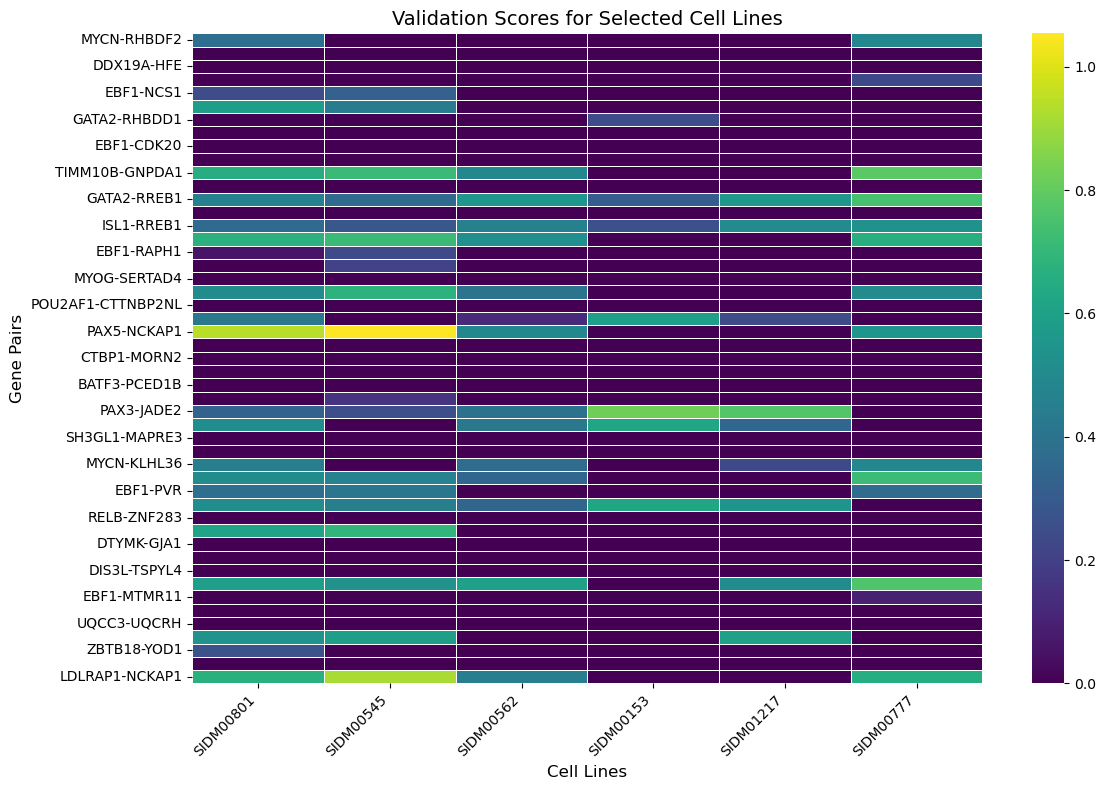

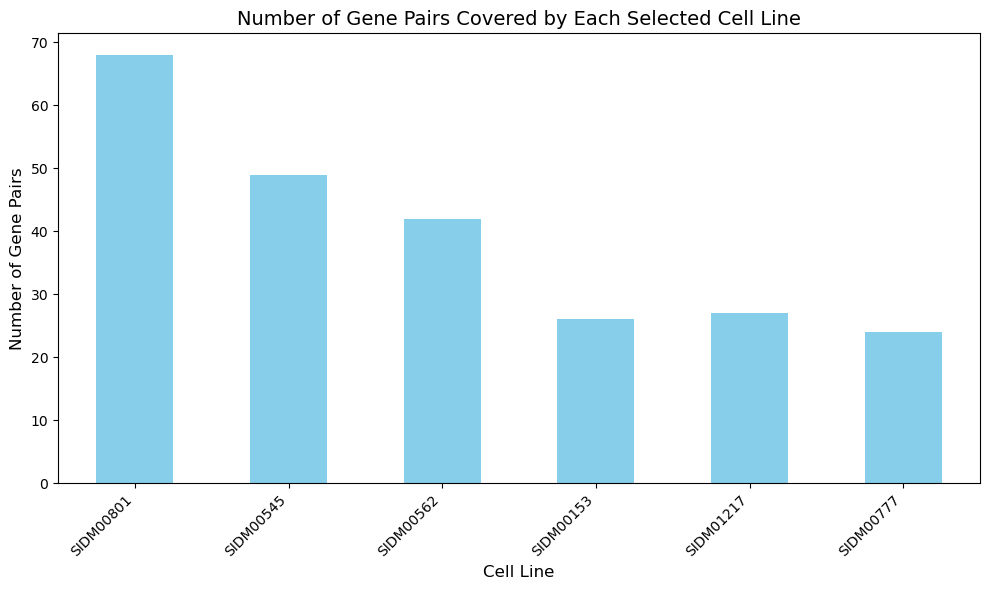

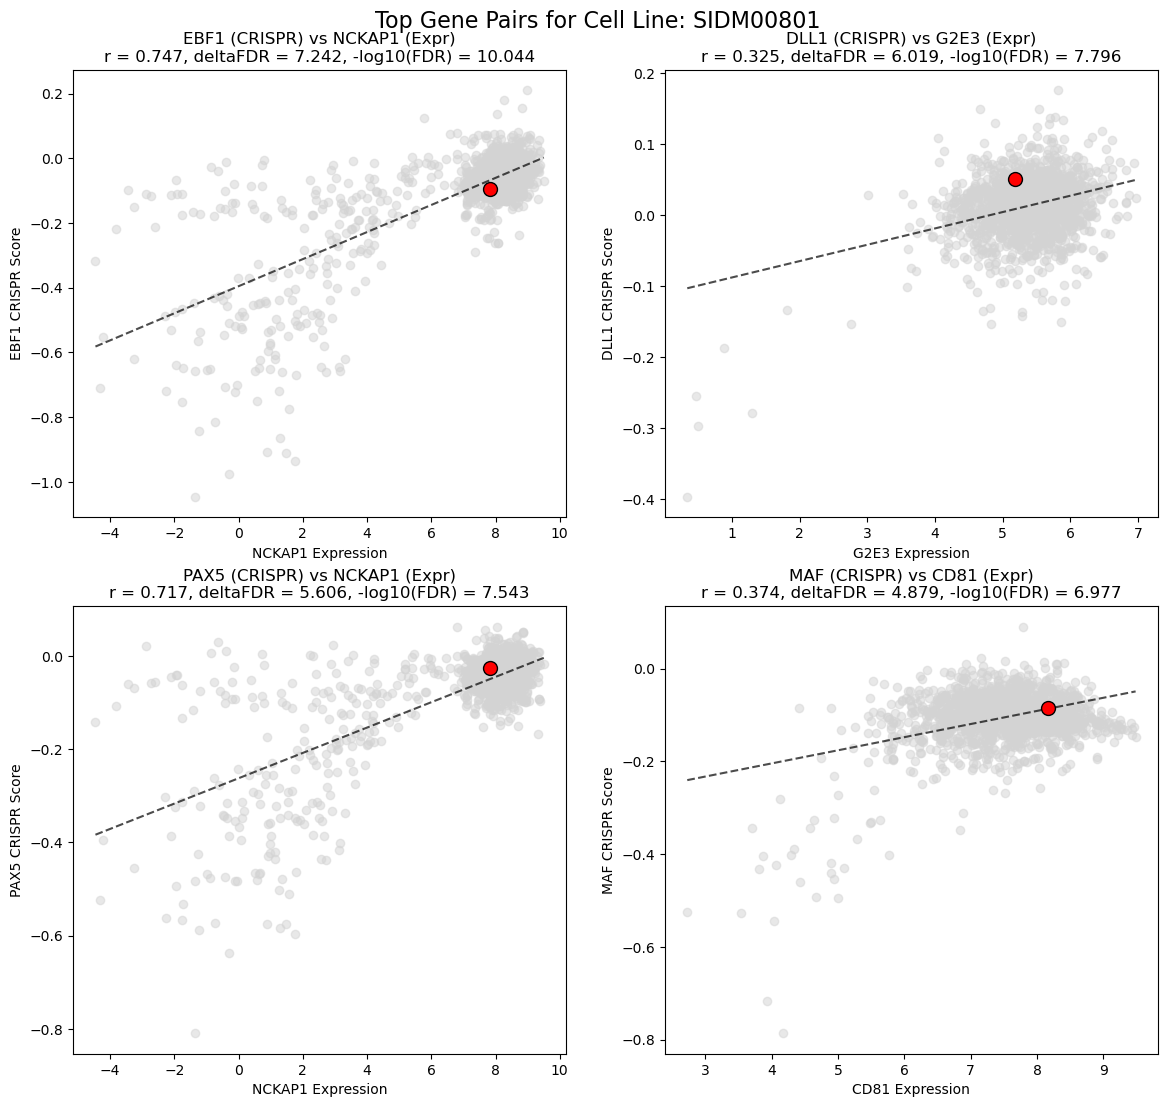

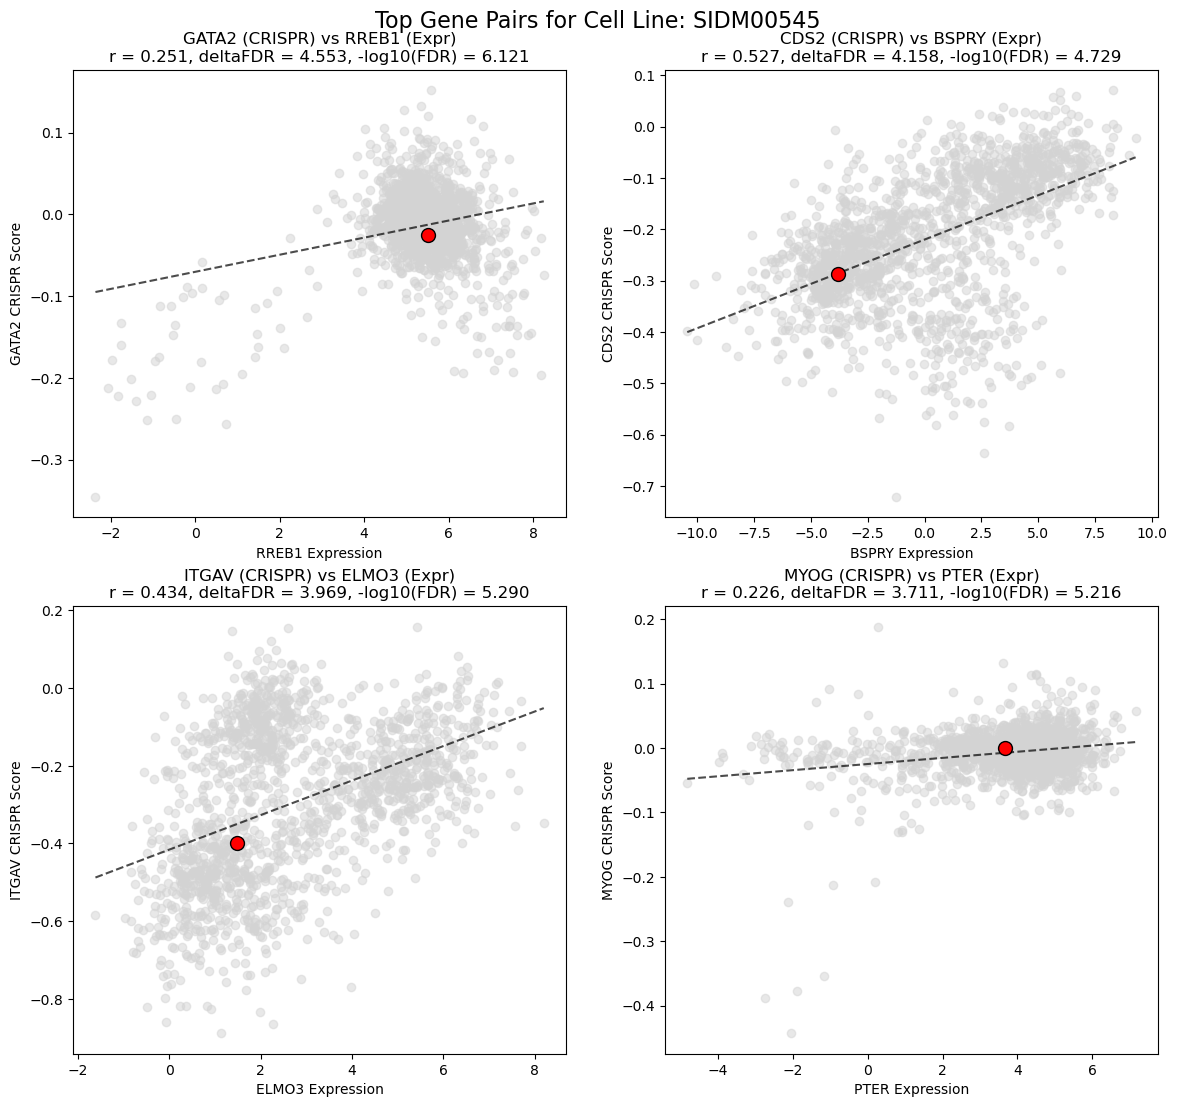

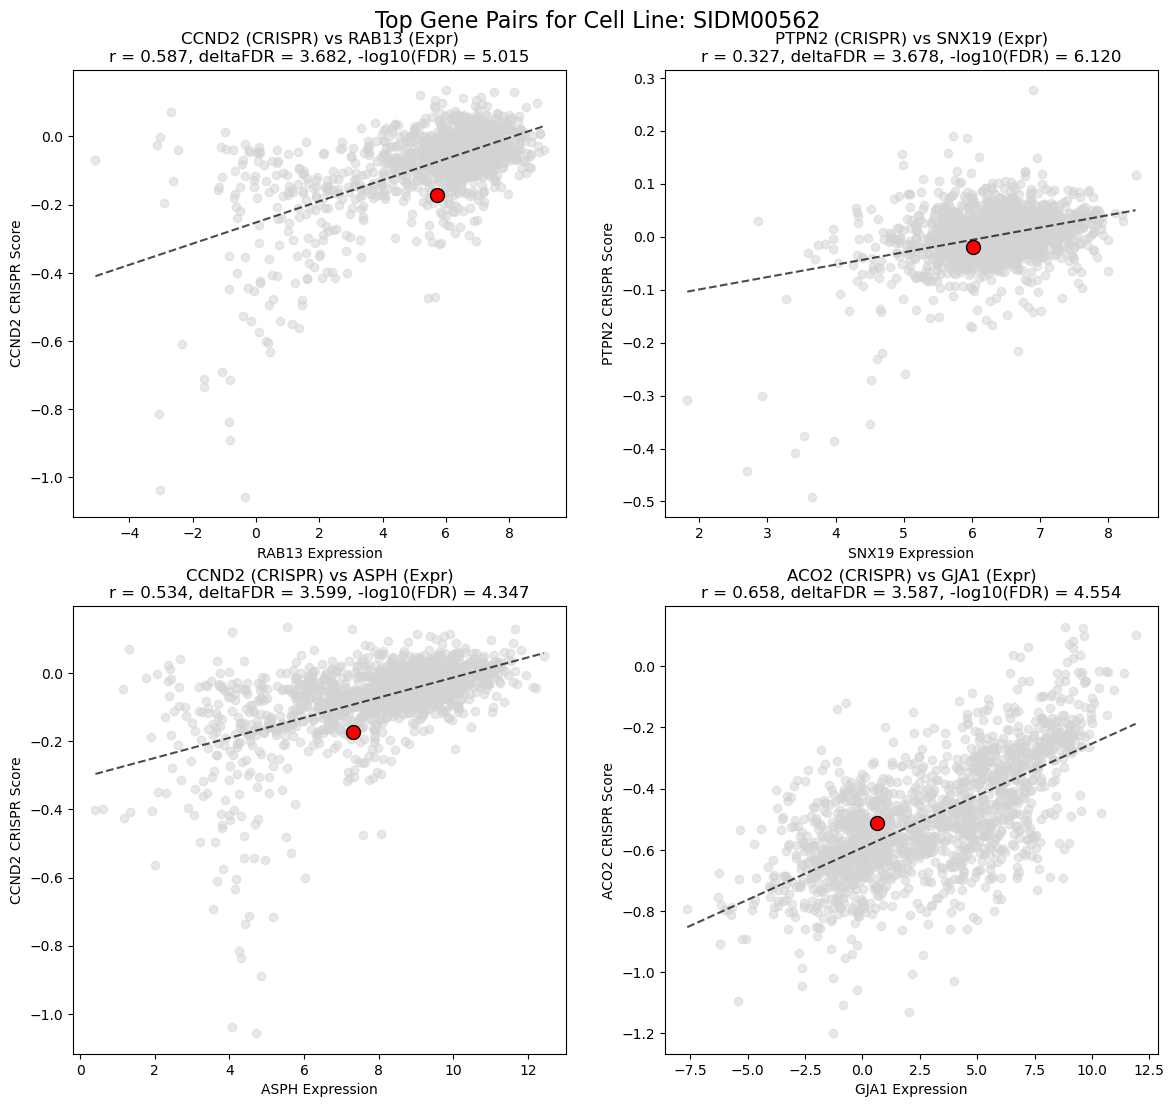

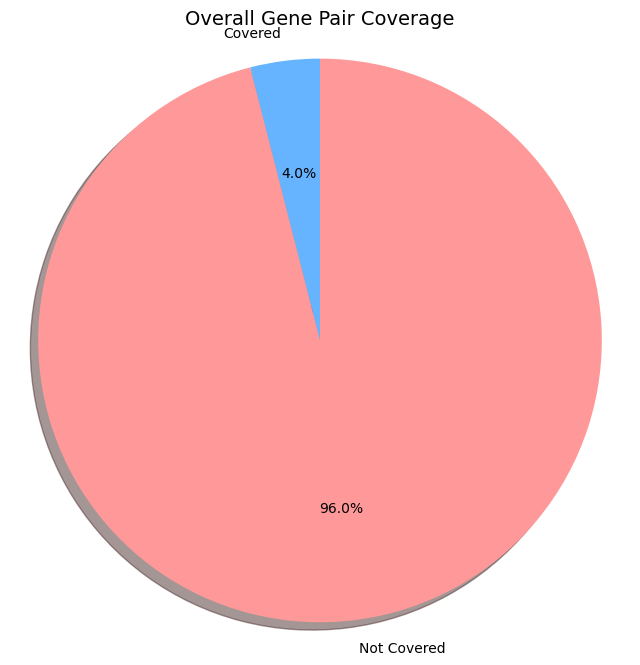

In [40]:
visualize_results(
    results=results,
    df_res_vae_filtered=df_res_vae_filtered,
    gexp_df=gexp_df,
    cas9_df=cas9_df,
    output_dir="./validation_results_remove_all_latent",
)

In [37]:
results["coverage_matrix"]

SIDM00001  SIDM00003  SIDM00005  SIDM00006  SIDM00007  \
cas9_gene gexp_gene                                                          
MARK2     LYSMD2             0          0          0          0          0   
MAF       ZNF77              0          0          0          0          0   
MICOS10   SERPINB6           0          0          0          0          0   
VPS4A     TMX3               0          0          0          0          0   
MEF2C     SNX33              0          0          0          0          0   
...                        ...        ...        ...        ...        ...   
EBF1      RAPH1              0          0          0          0          0   
TFRC      GJA1               0          0          0          0          0   
CDH2      PTK2B              1          0          0          0          0   
ISL1      RREB1              0          0          0          0          0   
CCND2     FKBP9              0          0          0          0          0   

                     SIDM00008  SIDM00011  SIDM00015  SIDM00016  SIDM00017  \
cas9_gene gexp_gene                                                          
MARK2     LYSMD2             0          0          0          0          0   
MAF       ZNF77              0          0          0          0          0   
MICOS10   SERPINB6           0          0          0          0          0   
VPS4A     TMX3               0          0          0          0          0   
MEF2C     SNX33              0          0          0          0          0   
...                        ...        ...        ...        ...        ...   
EBF1      RAPH1              0          0          0          0          0   
TFRC      GJA1               0          0          0          0          0   
CDH2      PTK2B              0          0          0          0          0   
ISL1      RREB1              0          0          0          0          0   
CCND2     FKBP9              0          1          0          0          0   

                     SIDM00018  SIDM00023  SIDM00026  SIDM00027  SIDM00028  \
cas9_gene gexp_gene                                                          
MARK2     LYSMD2             0          0          0          0          0   
MAF       ZNF77              0          0          0          0          0   
MICOS10   SERPINB6           0          0          0          0          0   
VPS4A     TMX3               0          0          0          0          0   
MEF2C     SNX33              0          0          0          0          0   
...                        ...        ...        ...        ...        ...   
EBF1      RAPH1              0          0          0          0          0   
TFRC      GJA1               0          0          0          0          0   
CDH2      PTK2B              1          0          0          0          0   
ISL1      RREB1              1          0          0          0          0   
CCND2     FKBP9              0          0          0          0          0   

                     ...  SIDM01969  SIDM01970  SIDM01971  SIDM01972  \
cas9_gene gexp_gene  ...                                               
MARK2     LYSMD2     ...          0          0          0          0   
MAF       ZNF77      ...          0          0          0          0   
MICOS10   SERPINB6   ...          0          0          0          0   
VPS4A     TMX3       ...          0          0          0          0   
MEF2C     SNX33      ...          0          0          0          0   
...                  ...        ...        ...        ...        ...   
EBF1      RAPH1      ...          0          0          0          0   
TFRC      GJA1       ...          0          0          0          0   
CDH2      PTK2B      ...          0          0          0          0   
ISL1      RREB1      ...          0          0          0          0   
CCND2     FKBP9      ...          0          0          0          1   

                     SIDM01973  SIDM019

In [38]:
# You can access the selected cell lines
selected_cell_lines = results["selected_cell_lines"]
print("Selected cell lines:", selected_cell_lines)

# Get the gene pairs that each cell line is best for demonstrating
for i, cell_line in enumerate(selected_cell_lines):
    examples = results["gene_pair_examples"][i]
    print(f"\nTop gene pairs for {cell_line}:")
    for cas9_gene, gexp_gene, score in examples[:10]:  # Show top 10
        print(f"  {cas9_gene} (CRISPR) - {gexp_gene} (Expr) - Score: {score:.4f}")

Selected cell lines: ['SIDM00801', 'SIDM00545', 'SIDM00562', 'SIDM00153', 'SIDM01217', 'SIDM00777']

Top gene pairs for SIDM00801:
  EBF1 (CRISPR) - NCKAP1 (Expr) - Score: 1.0000
  DLL1 (CRISPR) - G2E3 (Expr) - Score: 0.8288
  PAX5 (CRISPR) - NCKAP1 (Expr) - Score: 0.7710
  MAF (CRISPR) - CD81 (Expr) - Score: 0.6692
  EBF1 (CRISPR) - RAPH1 (Expr) - Score: 0.6554
  LDLRAP1 (CRISPR) - NCKAP1 (Expr) - Score: 0.6475
  HAND2 (CRISPR) - KLHL36 (Expr) - Score: 0.6460
  EBF1 (CRISPR) - NCS1 (Expr) - Score: 0.6373
  TIMM10B (CRISPR) - OCRL (Expr) - Score: 0.6000
  PGM3 (CRISPR) - GJA1 (Expr) - Score: 0.5782

Top gene pairs for SIDM00545:
  GATA2 (CRISPR) - RREB1 (Expr) - Score: 0.6235
  CDS2 (CRISPR) - BSPRY (Expr) - Score: 0.5683
  ITGAV (CRISPR) - ELMO3 (Expr) - Score: 0.5419
  MYOG (CRISPR) - PTER (Expr) - Score: 0.5057
  SOX11 (CRISPR) - TEP1 (Expr) - Score: 0.5023
  SOX11 (CRISPR) - RREB1 (Expr) - Score: 0.4991
  SH3GL1 (CRISPR) - ZCCHC14 (Expr) - Score: 0.4954
  ZBTB18 (CRISPR) - JADE2 (E